## Step1: Put all libraries and packages at top

In [1]:
# files and system
import os
import sys

In [2]:
import time
import random

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [3]:
# working with images
import cv2
import imageio
import scipy.ndimage
import skimage.transform

import torchvision.transforms as transforms

In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import torchsummary
from tqdm import notebook

## Step 2: Fix a seed for reproducibility, and choose the DEVICE

In [5]:
random_seed=42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu

## Step 3: Set your transforms, e.g, normalisation, resizing, rotation, flip, padding etc

In [7]:
_size = 256, 256
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180), # allow any rotation
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

## Step 4: Make your train and validation data loader with option to augment or not

In [8]:
# Method 2: Save images to folder and create a custom dataloader that loads them from their path. More involved than method 1 but allows for greater flexibility
# Requires 3 functions: __init__ to initialize the object, and __len__ and __get__item for pytorch purposes. More functions can be added as needed, but those 3 are necessary for it to function with pytorch
class myDataSet(object):

    def __init__(self, ids, path_images, path_masks, transforms):
        "Initialization"
        self.ids = ids
        self.path_images = path_images
        self.path_masks = path_masks
        self.transforms = transforms

    def __len__(self):
        "Returns length of dataset"
        return len(self.ids)  

    def __getitem__(self, index):
        "Return next item of dataset"
        # Define path to current image and corresponding mask
        path_img = os.path.join(self.path_images, self.ids[index])
        path_mask = os.path.join(self.path_masks, self.ids[index])

        # Load image and mask:
        #     .jpeg has 3 channels, channels recorded last
        #     .jpeg records values as intensities from 0 to 255
        #     masks for some reason have values different to 0 or 255: 0, 1, 2, 3, 4, 5, 6, 7, 248, 249, 250, 251, 252, 253, 254, 255
        img = imageio.imread(path_img) / 255
        mask = imageio.imread(path_mask)[:, :, 0] / 255
        mask = mask.round() # binarize to 0 or 1 
        
        # for debugging
        #
        # print(path_img)
        # print(img.shape, mask.shape)
        # print(np.unique(mask))
        # print(type(img), type(mask))
        # assert img.shape[0, 1] == mask.shape[0, 1]

        # transformations applied to the image/mask
        #
        # resize both
        # img = cv2.resize(img, (256, 256))
        # mask = cv2.resize(mask, (256, 256))
        
        # convert to Tensors and fix the dimentions
        img = torch.FloatTensor(np.transpose(img, [2, 0 ,1])) # Pytorch uses the channels in the first dimension
        mask = torch.FloatTensor(mask).unsqueeze(0) # Adding channel dimension to label
        
        # apply transforms/augmentation to both image and mask together
        sample = torch.cat((img, mask), 0) # insures that the same transform is applied
        sample = self.transforms(sample)
        img = sample[:img.shape[0], ...]
        mask = sample[img.shape[0]:, ...]

        return img, mask

path_images = "../datasets/train-val/images"
path_masks = "../datasets/train-val/masks"


# pre-defined split
with open('../2020-MediaEval-Medico-polyp-segmentation-master/kvasir-seg-train-val/train.txt', 'r') as f:
    ids_train = [l.strip()+'.jpg' for l in f]
with open('../2020-MediaEval-Medico-polyp-segmentation-master/kvasir-seg-train-val/val.txt', 'r') as f:
    ids_val = [l.strip()+'.jpg' for l in f]


custom_dataset_train = myDataSet(ids_train, path_images, path_masks, transforms=train_transforms)
custom_dataset_val = myDataSet(ids_val, path_images, path_masks, transforms=test_transforms)

print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))
print("My custom validation-dataset has {} elements".format(len(custom_dataset_val)))

My custom training-dataset has 880 elements
My custom validation-dataset has 120 elements


In [9]:
BATCH_SIZE = 20

# Create dataloaders from datasets with the native pytorch functions
dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

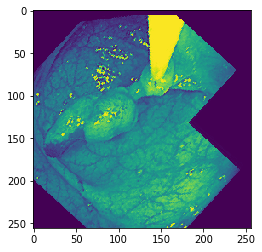

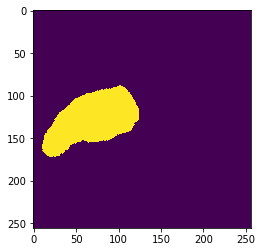

In [10]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)


# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()

In [11]:
custom_dataset_train.__getitem__(image_number)[0].shape

torch.Size([3, 256, 256])

In [12]:
custom_dataset_train.__getitem__(image_number)[1].shape, np.unique(custom_dataset_train.__getitem__(image_number)[1])

(torch.Size([1, 256, 256]), array([0., 1.], dtype=float32))

# Losses

Credit to: https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch

In [13]:
def iou_pytorch_eval(outputs: torch.Tensor, labels: torch.Tensor):

    # comment out if your model contains a sigmoid or equivalent activation layer
    outputs = torch.sigmoid(outputs)

    # thresholding since that's how we will make predictions on new imputs
    outputs = outputs > 0.5

    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()


    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    return iou.mean()

In [14]:
def iou_pytorch_test(outputs: torch.Tensor, labels: torch.Tensor):
    
    # BATCH x H x W
    assert len(outputs.shape) == 3
    assert len(labels.shape) == 3

    # comment out if your model contains a sigmoid or equivalent activation layer
    outputs = torch.sigmoid(outputs)

    # thresholding since that's how we will make predictions on new imputs
    outputs = outputs > 0.5
    labels = labels > 0.5

    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    return iou.mean()

In [15]:
#PyTorch
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return -IoU

#PyTorch
class IoUBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoUBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = - (intersection + smooth)/(union + smooth)
        
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        IoU_BCE = BCE + IoU
                
        return IoU_BCE

# Model Architecture

In [16]:
# Define your model. In this case we're using a basic UNet architecture. The output channel for segmentation should be equal to number of classes we want to segment the image into. For a binary segmentation, this is a value of 1.
class UNet(torch.nn.Module):

    def conv_block(self, channel_in, channel_out):
        return torch.nn.Sequential(
            torch.nn.Conv2d(channel_in, channel_out, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(channel_out),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(channel_out, channel_out, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(channel_out),
            torch.nn.ReLU(inplace=True)
        )


    def __init__(self, channel_in, channel_out, bilinear=None):
        super(UNet, self).__init__()
        self.channel_in = channel_in
        self.channel_out = channel_out
        
        # initial convolutional block
        self.initial = self.conv_block(channel_in, 64)
        
        # encoder layers
        self.down0 = self.conv_block(64, 128)
        self.down1 = self.conv_block(128, 256)
        self.down2 = self.conv_block(256, 512)
        self.down3 = self.conv_block(512, 1024)
        
        # decoder layers
        self.up0_0 = torch.nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up0_1 = self.conv_block(1024, 512)
        self.up1_0 = torch.nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up1_1 = self.conv_block(512, 256)
        self.up2_0 = torch.nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up2_1 = self.conv_block(256, 128)
        self.up3_0 = torch.nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up3_1 = self.conv_block(128, 64)
        
        # final layer before output
        self.final = torch.nn.Conv2d(64, channel_out, kernel_size=1)

    def forward(self,x):
        "Forward pass"
        x_in= self.initial(x)
        enc0 = self.down0(torch.nn.MaxPool2d(2)(x_in))
        enc1 = self.down1(torch.nn.MaxPool2d(2)(enc0))
        enc2 = self.down2(torch.nn.MaxPool2d(2)(enc1))
        enc3 = self.down3(torch.nn.MaxPool2d(2)(enc2))
        
        dec0 = self.up0_0(enc3)
        diff0 = torch.FloatTensor(list(enc2.size())[2:]) - torch.FloatTensor(list(dec0.shape))[2:]
        dec0 = torch.nn.functional.pad(dec0, (int((diff0/2).floor()[0]), int((diff0/2).ceil()[0]), int((diff0/2).floor()[1]), int((diff0/2).ceil()[1])))
        dec0 = self.up0_1(torch.cat((enc2, dec0), dim=1))

        dec1 = self.up1_0(dec0)
        diff1 = torch.FloatTensor(list(enc1.size())[2:]) - torch.FloatTensor(list(dec1.shape))[2:]
        dec1 = torch.nn.functional.pad(dec1, (int((diff1/2).floor()[0]), int((diff1/2).ceil()[0]), int((diff1/2).floor()[1]), int((diff1/2).ceil()[1])))
        dec1 = self.up1_1(torch.cat((enc1, dec1), dim=1))

        dec2 = self.up2_0(dec1)
        diff2 = torch.FloatTensor(list(enc0.size())[2:]) - torch.FloatTensor(list(dec2.shape))[2:]
        dec2 = torch.nn.functional.pad(dec2, (int((diff2/2).floor()[0]), int((diff2/2).ceil()[0]), int((diff2/2).floor()[1]), int((diff2/2).ceil()[1])))
        dec2 = self.up2_1(torch.cat((enc0, dec2), dim=1))

        dec3 = self.up3_0(dec2)
        diff3 = torch.FloatTensor(list(x.size())[2:]) - torch.FloatTensor(list(dec3.shape))[2:]
        dec3 = torch.nn.functional.pad(dec3, (int((diff3/2).floor()[0]), int((diff3/2).ceil()[0]), int((diff3/2).floor()[1]), int((diff3/2).ceil()[1])))
        dec3 = self.up3_1(torch.cat((x_in, dec3), dim=1))
        
        x_out = self.final(dec3) # ? no activation here
        return x_out

model = UNet(channel_in=3, channel_out=1)
torchsummary.summary(model, (3, 256, 256), device='cpu') # Runs a basic test of the network. Very useful and clear!

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
            Conv2d-7        [-1, 128, 128, 128]          73,856
       BatchNorm2d-8        [-1, 128, 128, 128]             256
              ReLU-9        [-1, 128, 128, 128]               0
           Conv2d-10        [-1, 128, 128, 128]         147,584
      BatchNorm2d-11        [-1, 128, 128, 128]             256
             ReLU-12        [-1, 128, 128, 128]               0
           Conv2d-13          [-1, 256, 64, 64]         295,168
      BatchNorm2d-14          [-1, 256,

## Pipeline

In [17]:
def train(model, optim, criterion, dataloader, epoch, device):
    pass

In [18]:
def test(model, criterion, dataloader, epoch, device, best_acc, model_name='model'):
    pass

# Training hyperparameters

In [19]:
# Begin training
model = UNet(channel_in=3, channel_out=1)
model = model.to(DEVICE) # load model to DEVICE

In [20]:
# Define variables for the training
epochs = 70

In [21]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimiser = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

# criterion = nn.BCEWithLogitsLoss()
# model_name = 'UNet_BCEWithLogitsLoss_augmented'

criterion = IoULoss()
model_name = 'UNet_IoULoss_augmented'

# criterion = IoUBCELoss()
# model_name = 'UNet_IoUBCELoss_augmented'


# Training

 Epoch: 0 of 70, Iter.: 44 of 44, Loss: -0.229322, Val. Loss: -0.208037
 Epoch: 0 of 70, Iter.: 44 of 44, IoU: 0.303356, Val. IoU: 0.221607


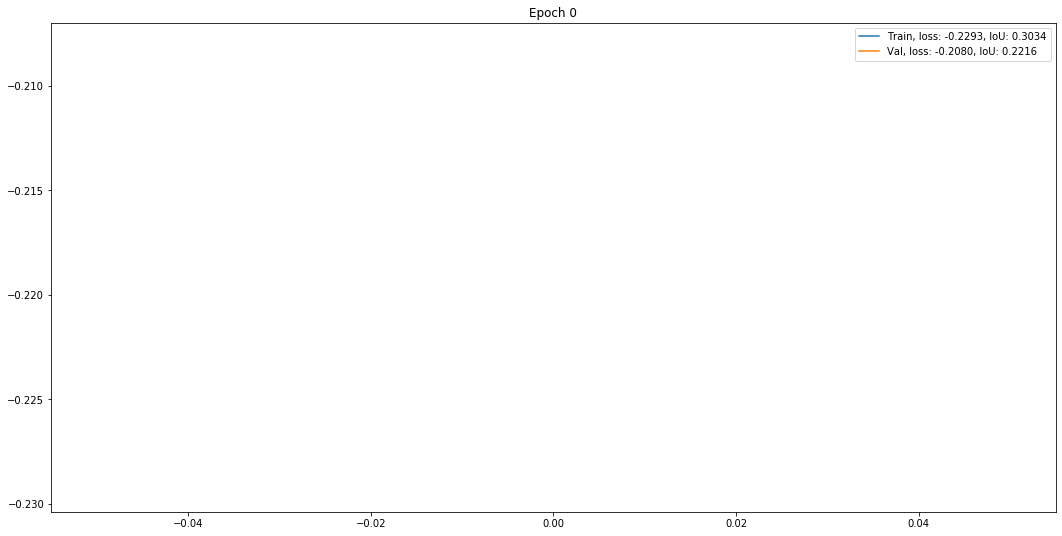

 Epoch: 1 of 70, Iter.: 44 of 44, Loss: -0.272546, Val. Loss: -0.259070
 Epoch: 1 of 70, Iter.: 44 of 44, IoU: 0.358199, Val. IoU: 0.306347


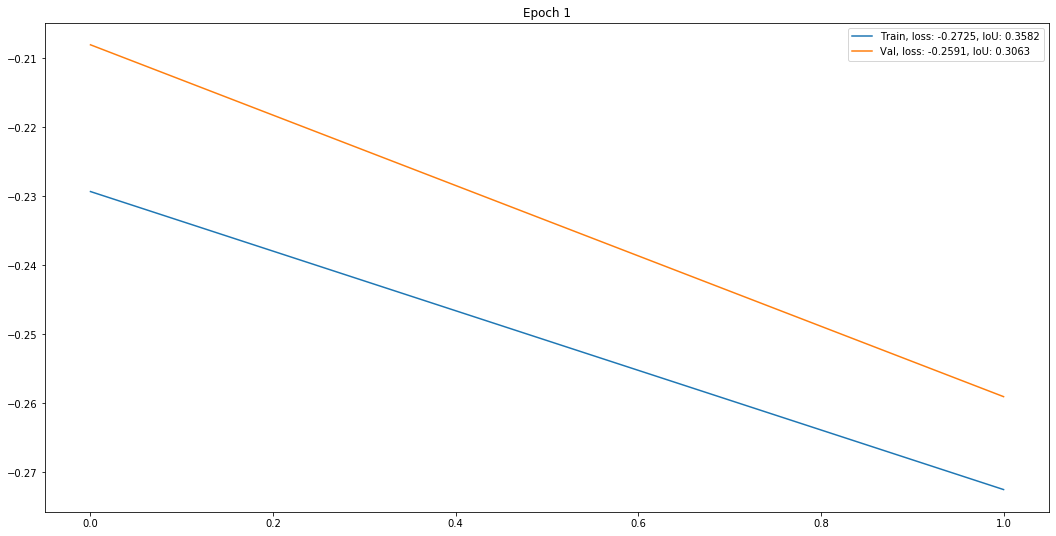

 Epoch: 2 of 70, Iter.: 44 of 44, Loss: -0.297338, Val. Loss: -0.271319
 Epoch: 2 of 70, Iter.: 44 of 44, IoU: 0.388275, Val. IoU: 0.381836


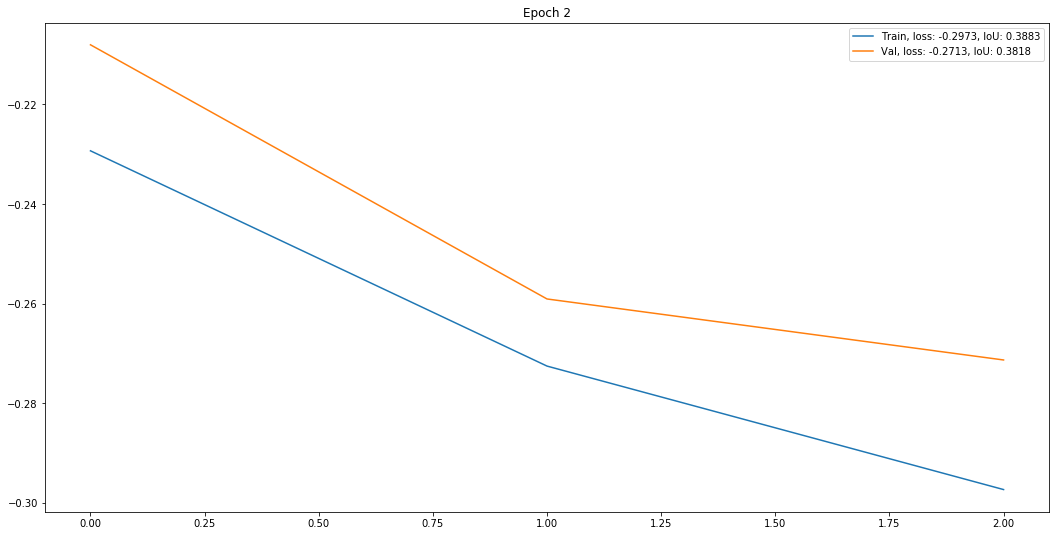

 Epoch: 3 of 70, Iter.: 44 of 44, Loss: -0.312133, Val. Loss: -0.281449
 Epoch: 3 of 70, Iter.: 44 of 44, IoU: 0.405186, Val. IoU: 0.328463


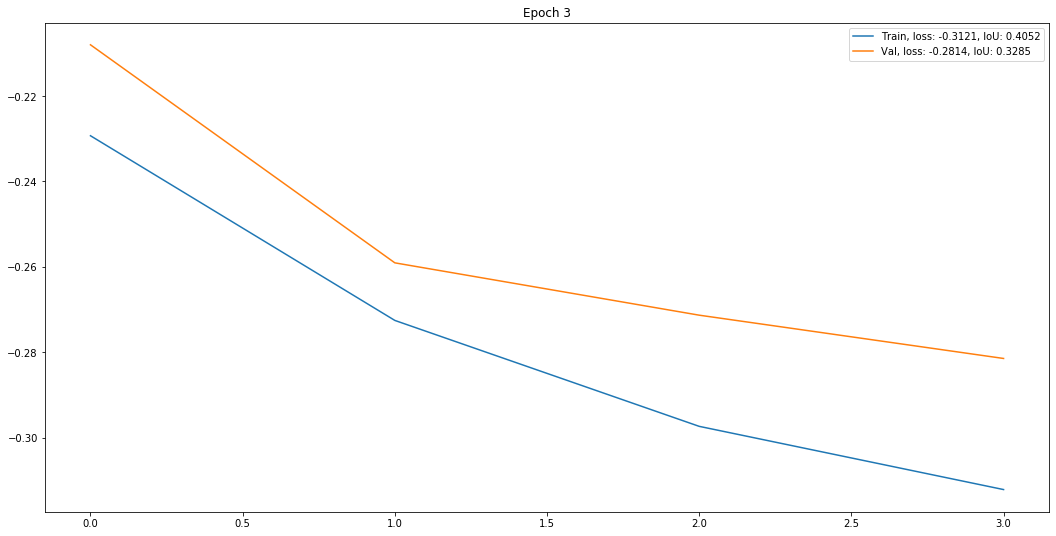

 Epoch: 4 of 70, Iter.: 44 of 44, Loss: -0.324807, Val. Loss: -0.276084
 Epoch: 4 of 70, Iter.: 44 of 44, IoU: 0.409872, Val. IoU: 0.306702


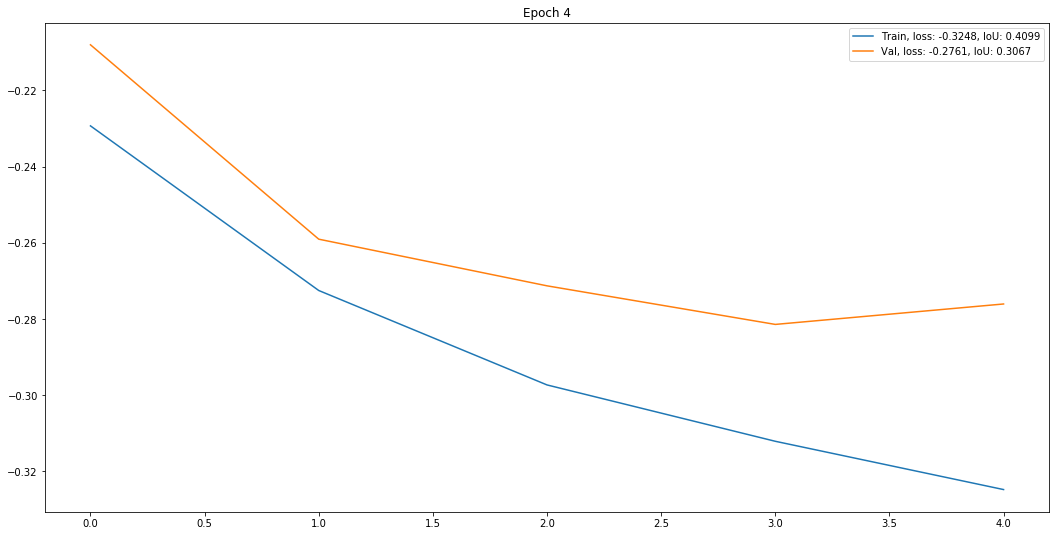

 Epoch: 5 of 70, Iter.: 44 of 44, Loss: -0.337495, Val. Loss: -0.328692
 Epoch: 5 of 70, Iter.: 44 of 44, IoU: 0.412728, Val. IoU: 0.379200


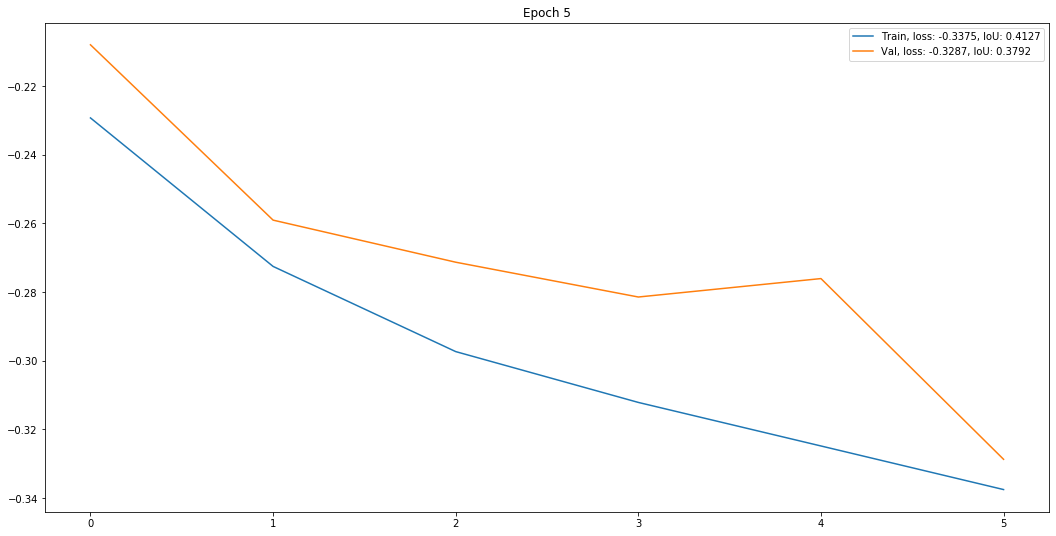

 Epoch: 6 of 70, Iter.: 44 of 44, Loss: -0.356012, Val. Loss: -0.340450
 Epoch: 6 of 70, Iter.: 44 of 44, IoU: 0.437046, Val. IoU: 0.418523


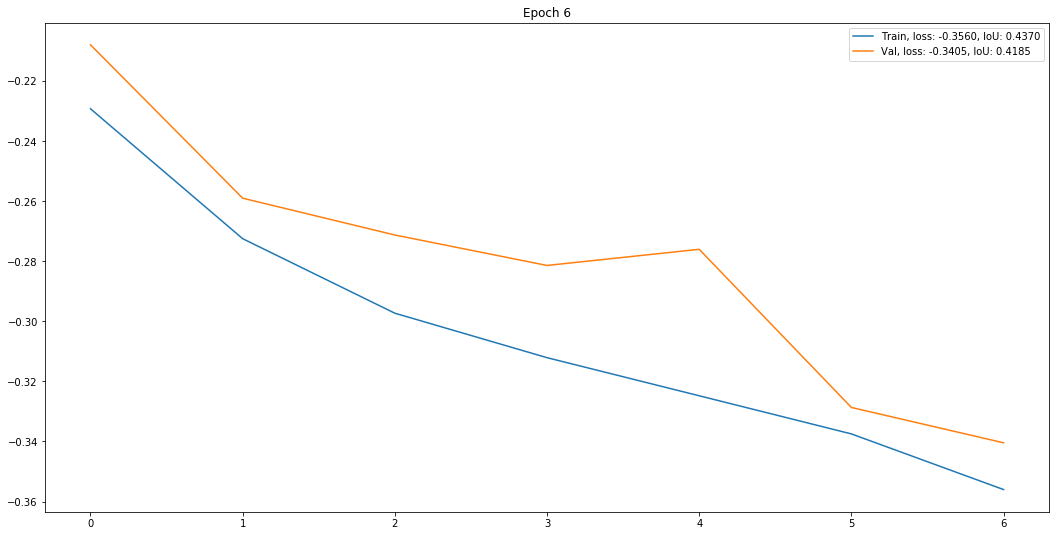

 Epoch: 7 of 70, Iter.: 44 of 44, Loss: -0.367094, Val. Loss: -0.308429
 Epoch: 7 of 70, Iter.: 44 of 44, IoU: 0.445011, Val. IoU: 0.342515


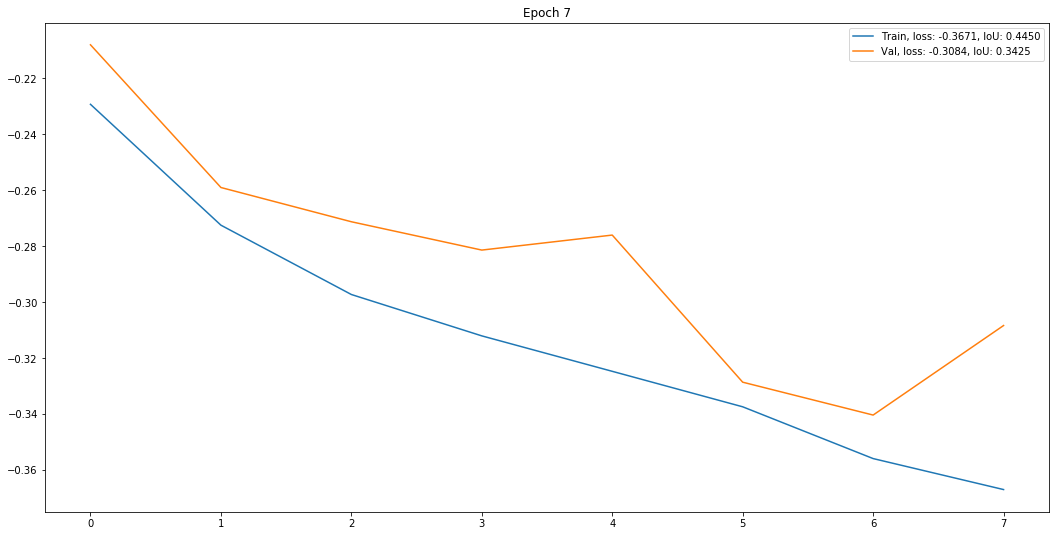

 Epoch: 8 of 70, Iter.: 44 of 44, Loss: -0.384142, Val. Loss: -0.333032
 Epoch: 8 of 70, Iter.: 44 of 44, IoU: 0.464271, Val. IoU: 0.375637


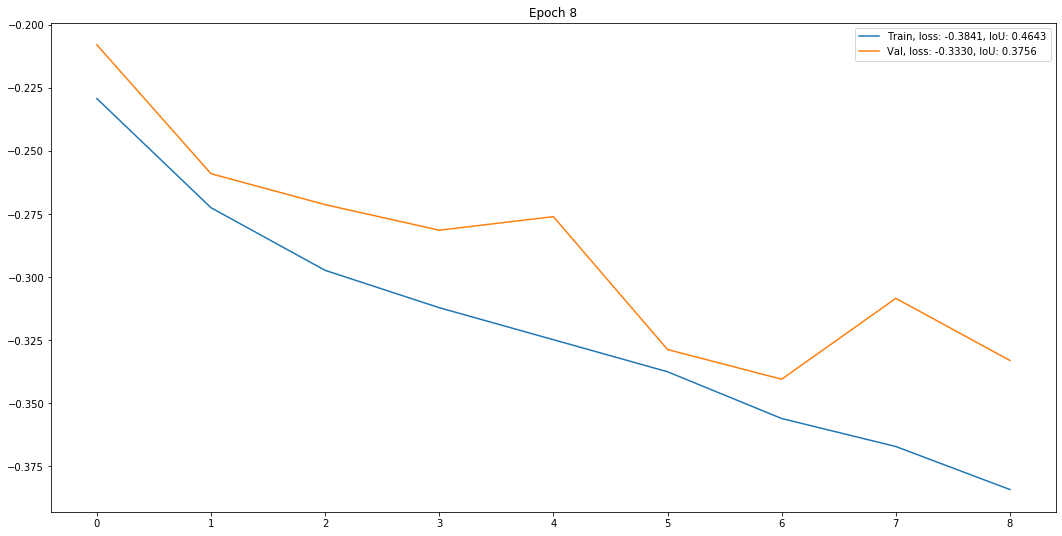

 Epoch: 9 of 70, Iter.: 44 of 44, Loss: -0.394117, Val. Loss: -0.316927
 Epoch: 9 of 70, Iter.: 44 of 44, IoU: 0.470662, Val. IoU: 0.359359


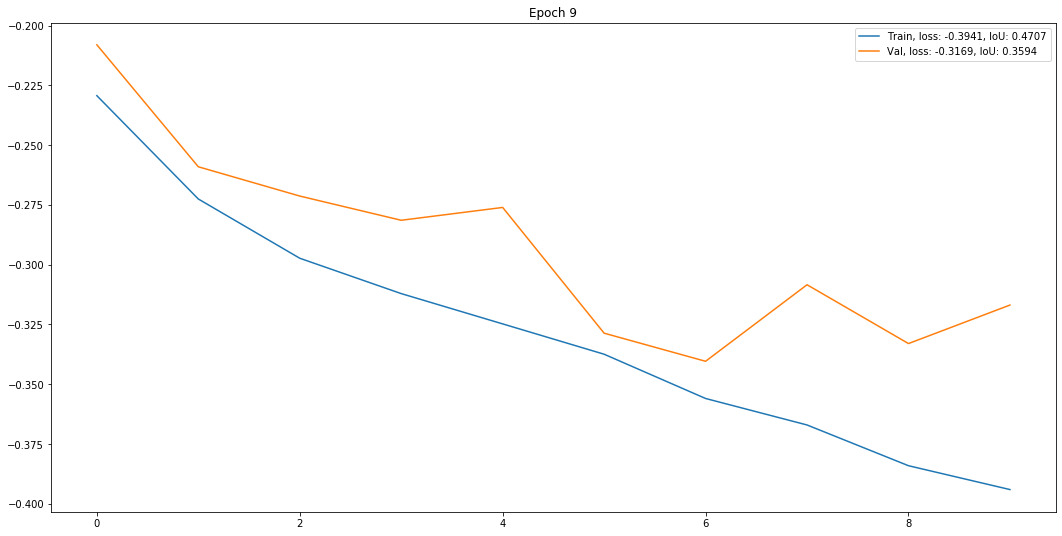

 Epoch: 10 of 70, Iter.: 44 of 44, Loss: -0.414234, Val. Loss: -0.363212
 Epoch: 10 of 70, Iter.: 44 of 44, IoU: 0.497383, Val. IoU: 0.439939


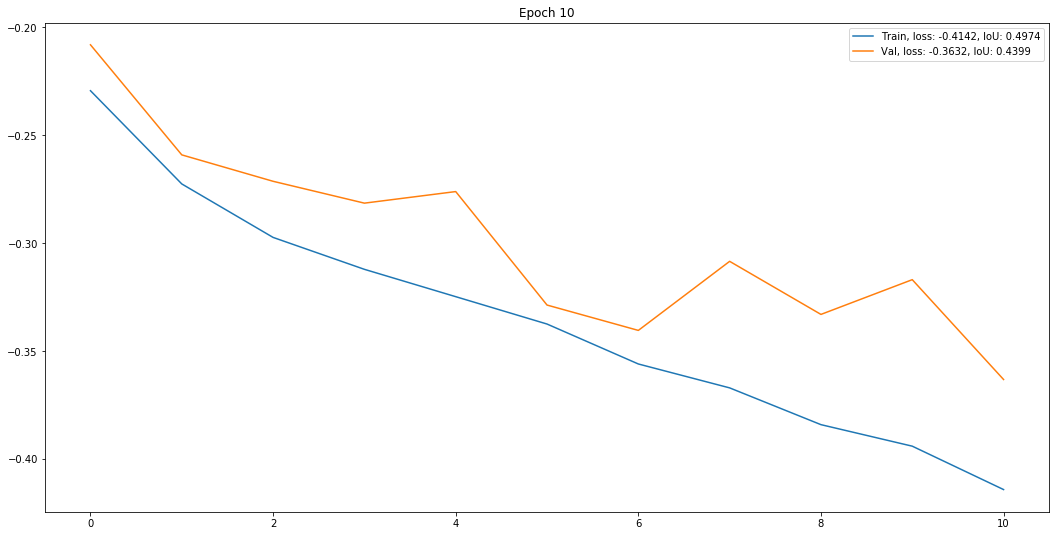

 Epoch: 11 of 70, Iter.: 44 of 44, Loss: -0.424566, Val. Loss: -0.382557
 Epoch: 11 of 70, Iter.: 44 of 44, IoU: 0.511663, Val. IoU: 0.440948


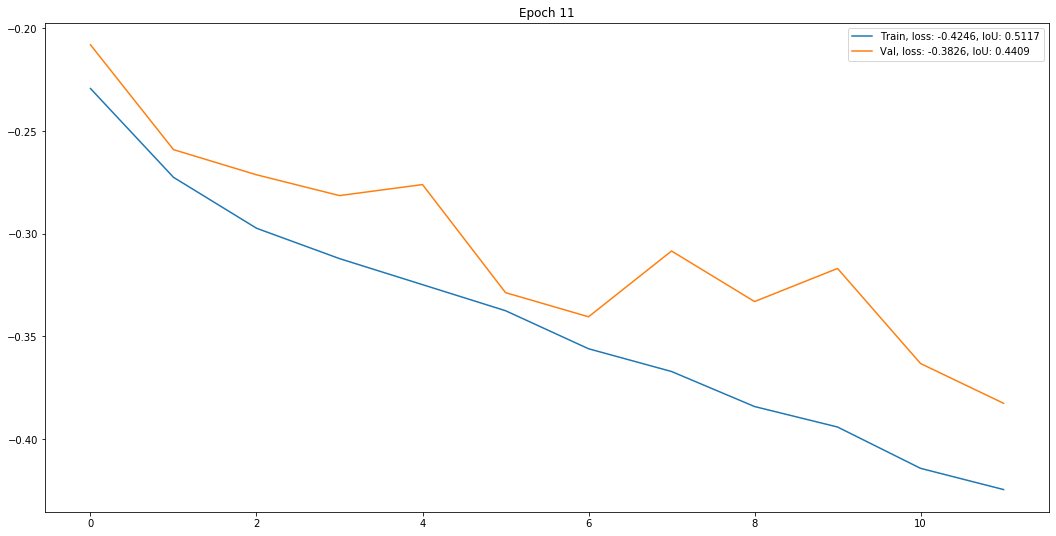

 Epoch: 12 of 70, Iter.: 44 of 44, Loss: -0.451239, Val. Loss: -0.426491
 Epoch: 12 of 70, Iter.: 44 of 44, IoU: 0.537136, Val. IoU: 0.497348


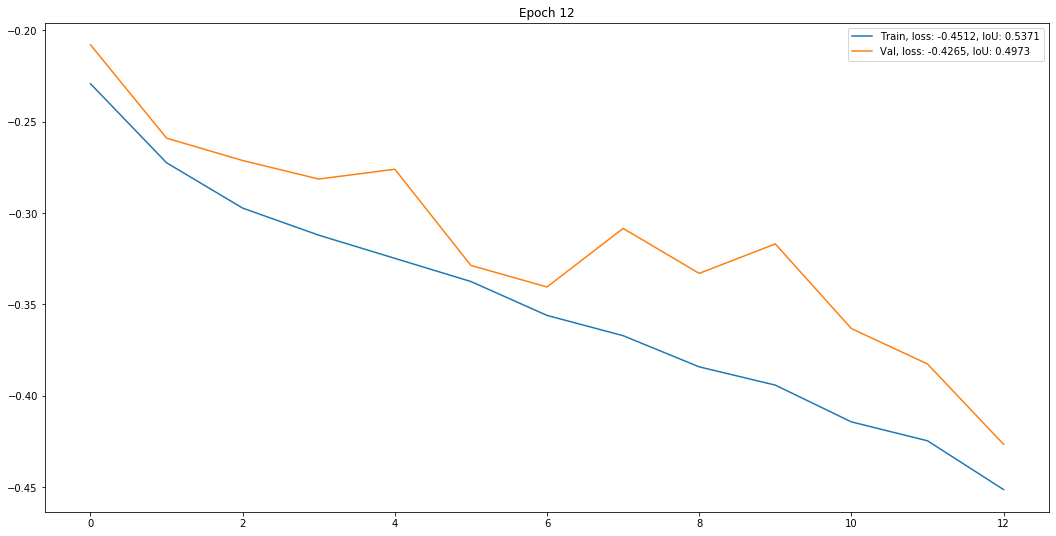

 Epoch: 13 of 70, Iter.: 44 of 44, Loss: -0.472479, Val. Loss: -0.437426
 Epoch: 13 of 70, Iter.: 44 of 44, IoU: 0.552694, Val. IoU: 0.505163


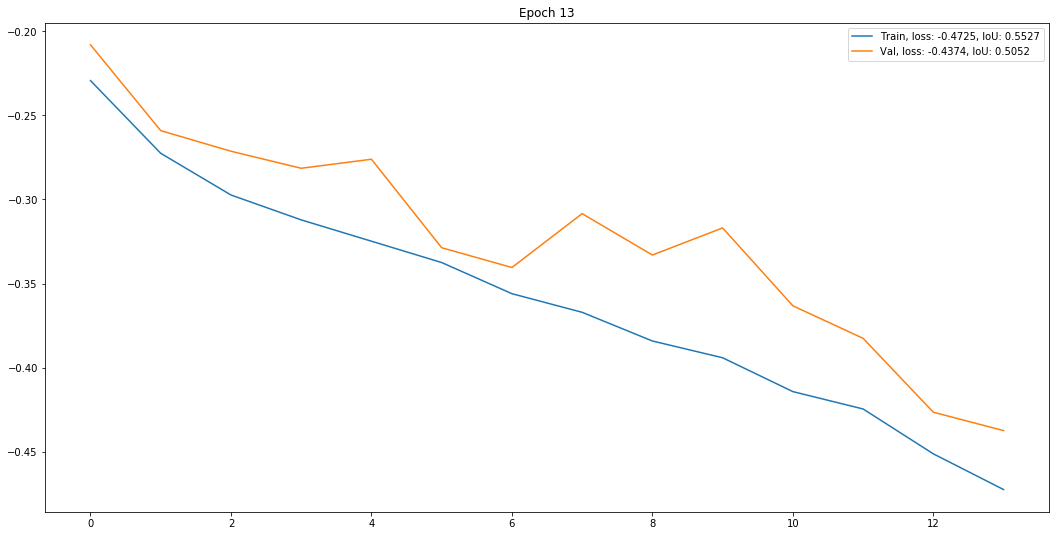

 Epoch: 14 of 70, Iter.: 44 of 44, Loss: -0.487071, Val. Loss: -0.391379
 Epoch: 14 of 70, Iter.: 44 of 44, IoU: 0.568886, Val. IoU: 0.435250


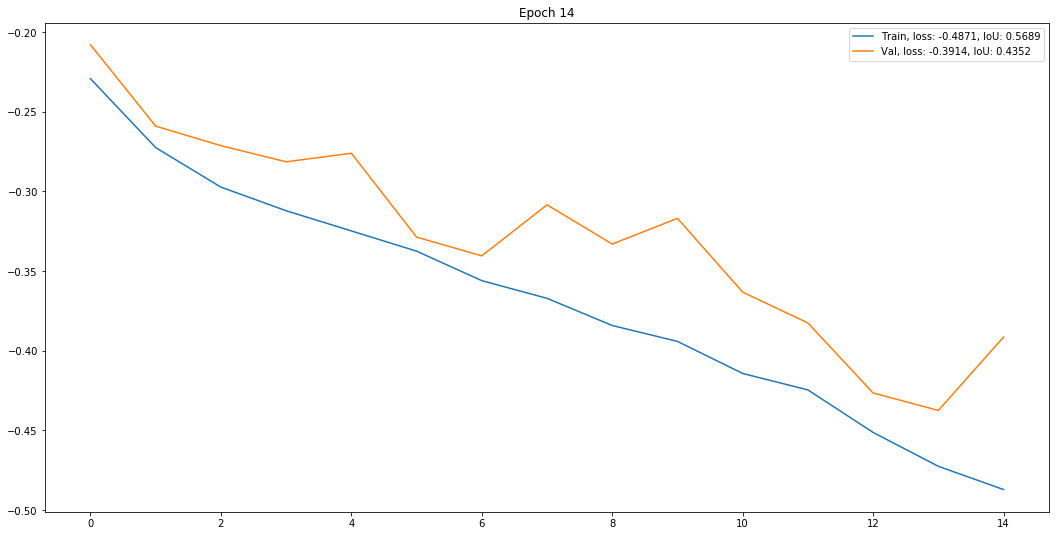

 Epoch: 15 of 70, Iter.: 44 of 44, Loss: -0.505509, Val. Loss: -0.461879
 Epoch: 15 of 70, Iter.: 44 of 44, IoU: 0.582378, Val. IoU: 0.522055


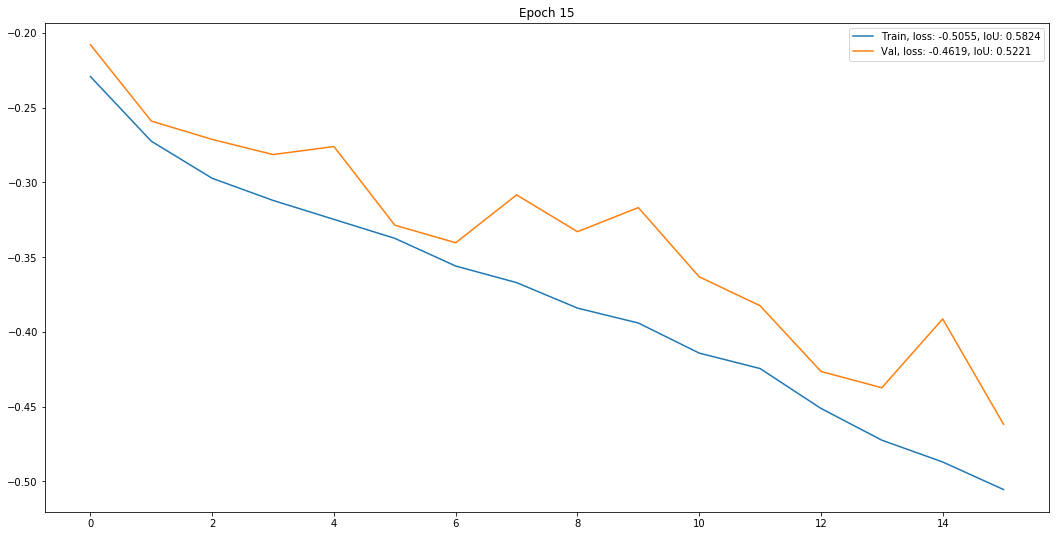

 Epoch: 16 of 70, Iter.: 44 of 44, Loss: -0.519258, Val. Loss: -0.500130
 Epoch: 16 of 70, Iter.: 44 of 44, IoU: 0.607152, Val. IoU: 0.567699


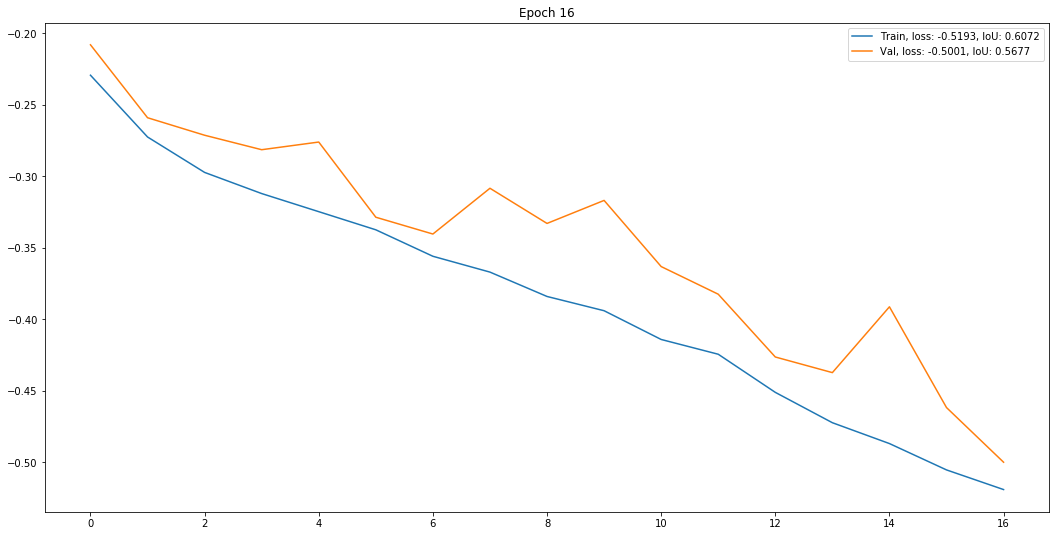

 Epoch: 17 of 70, Iter.: 44 of 44, Loss: -0.539847, Val. Loss: -0.462370
 Epoch: 17 of 70, Iter.: 44 of 44, IoU: 0.618291, Val. IoU: 0.512412


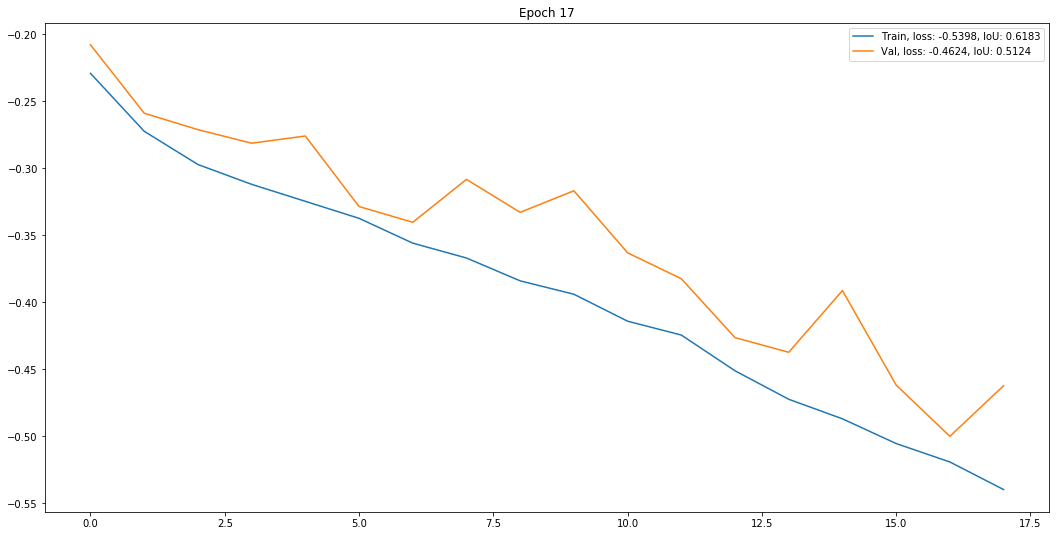

 Epoch: 18 of 70, Iter.: 44 of 44, Loss: -0.542791, Val. Loss: -0.485644
 Epoch: 18 of 70, Iter.: 44 of 44, IoU: 0.616327, Val. IoU: 0.556472


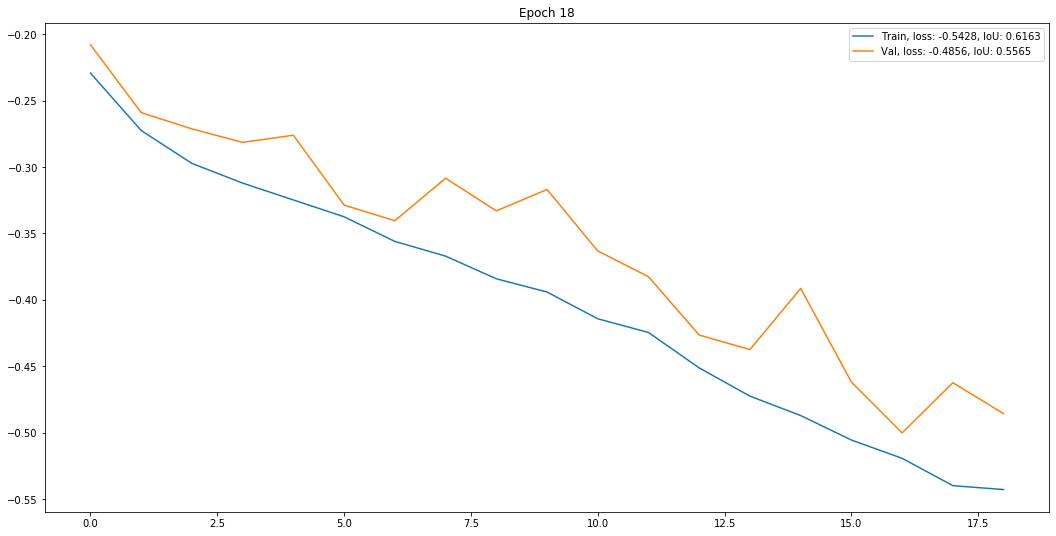

 Epoch: 19 of 70, Iter.: 44 of 44, Loss: -0.553027, Val. Loss: -0.497895
 Epoch: 19 of 70, Iter.: 44 of 44, IoU: 0.625251, Val. IoU: 0.543900


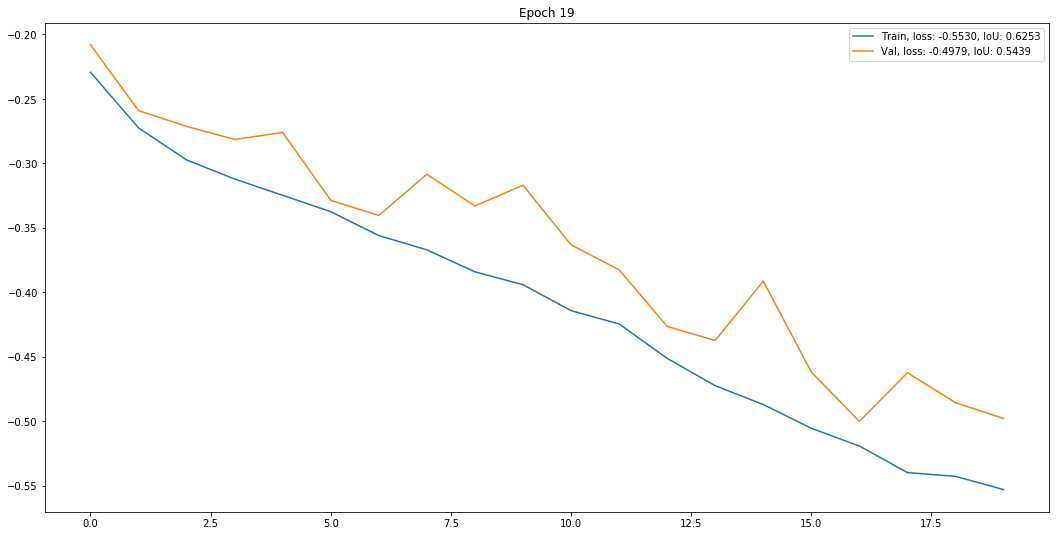

 Epoch: 20 of 70, Iter.: 44 of 44, Loss: -0.574803, Val. Loss: -0.483817
 Epoch: 20 of 70, Iter.: 44 of 44, IoU: 0.643065, Val. IoU: 0.542949


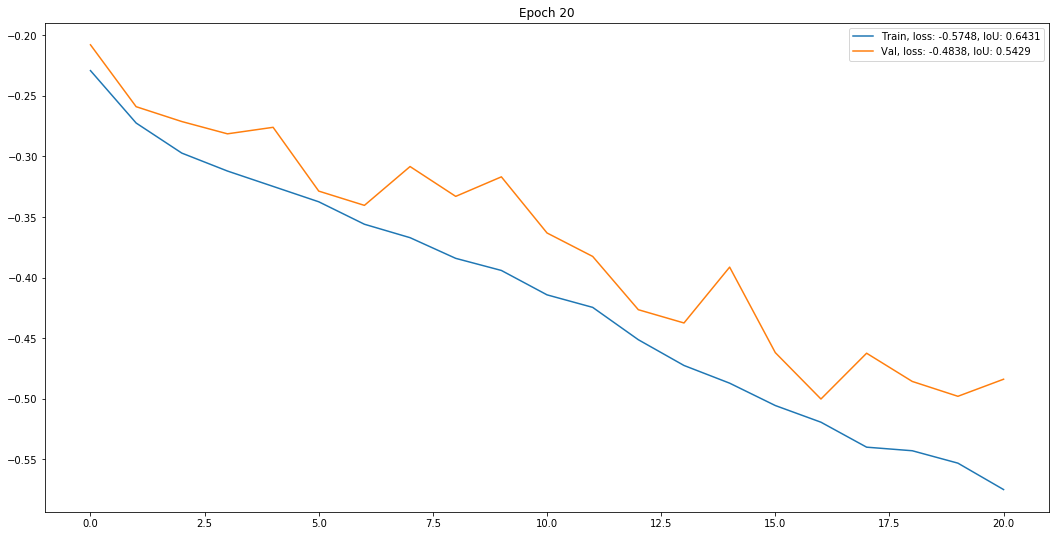

 Epoch: 21 of 70, Iter.: 44 of 44, Loss: -0.587816, Val. Loss: -0.431711
 Epoch: 21 of 70, Iter.: 44 of 44, IoU: 0.652637, Val. IoU: 0.468281


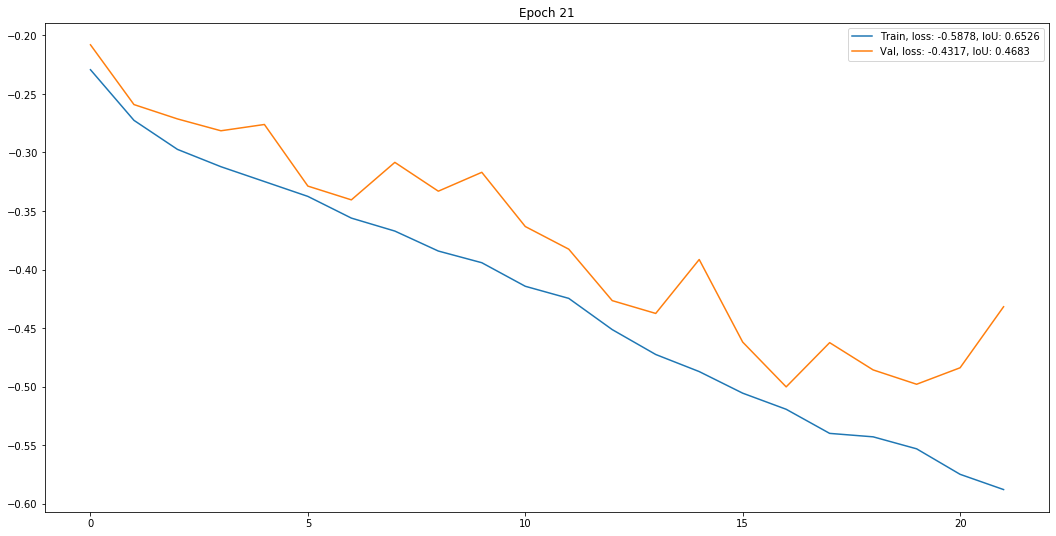

 Epoch: 22 of 70, Iter.: 44 of 44, Loss: -0.594409, Val. Loss: -0.481236
 Epoch: 22 of 70, Iter.: 44 of 44, IoU: 0.649783, Val. IoU: 0.514801


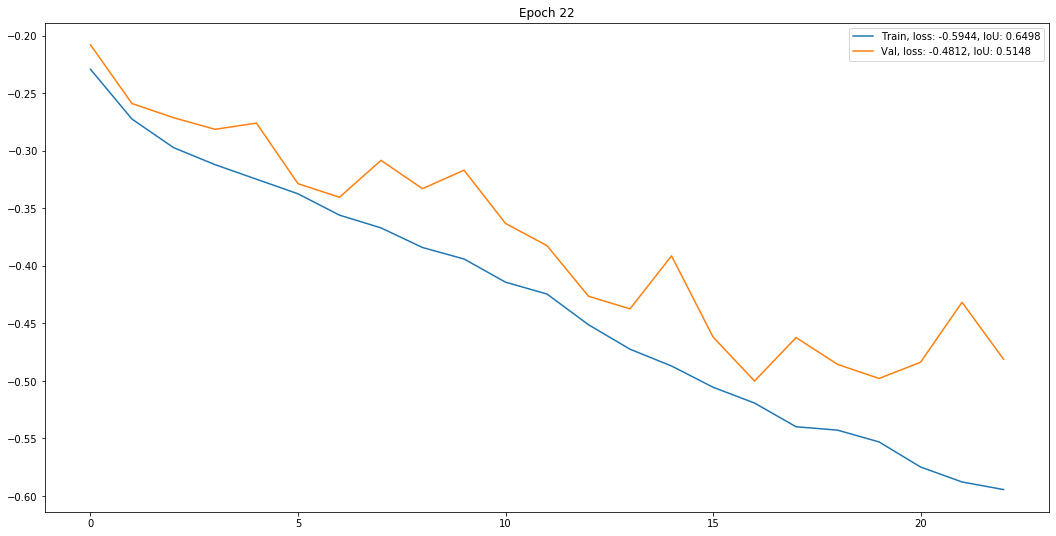

 Epoch: 23 of 70, Iter.: 44 of 44, Loss: -0.600802, Val. Loss: -0.487547
 Epoch: 23 of 70, Iter.: 44 of 44, IoU: 0.655927, Val. IoU: 0.521079


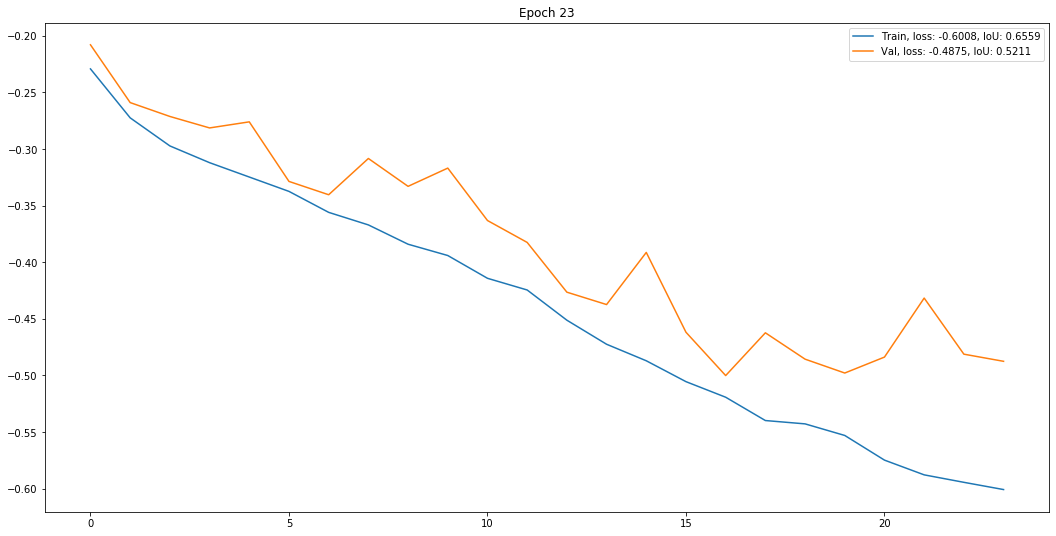

 Epoch: 24 of 70, Iter.: 44 of 44, Loss: -0.608858, Val. Loss: -0.472252
 Epoch: 24 of 70, Iter.: 44 of 44, IoU: 0.663665, Val. IoU: 0.489361


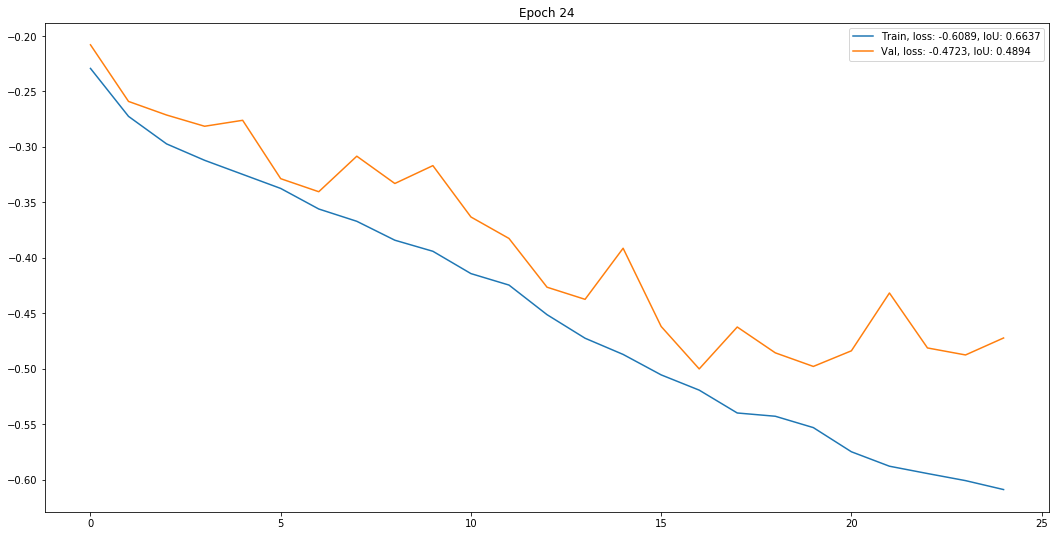

 Epoch: 25 of 70, Iter.: 44 of 44, Loss: -0.625880, Val. Loss: -0.438478
 Epoch: 25 of 70, Iter.: 44 of 44, IoU: 0.671856, Val. IoU: 0.455351


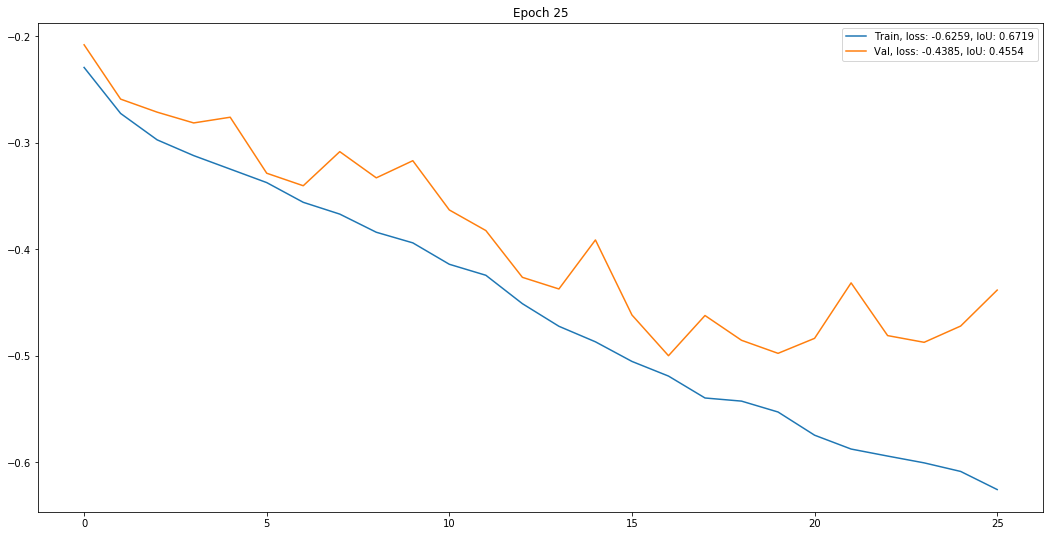

 Epoch: 26 of 70, Iter.: 44 of 44, Loss: -0.624779, Val. Loss: -0.492302
 Epoch: 26 of 70, Iter.: 44 of 44, IoU: 0.673417, Val. IoU: 0.516362


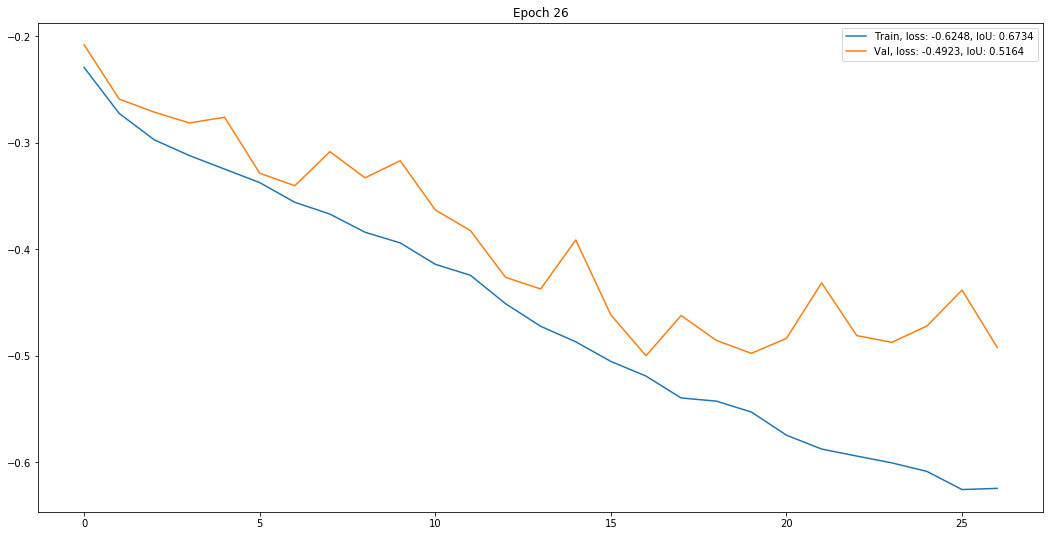

 Epoch: 27 of 70, Iter.: 44 of 44, Loss: -0.631393, Val. Loss: -0.536713
 Epoch: 27 of 70, Iter.: 44 of 44, IoU: 0.675726, Val. IoU: 0.551154


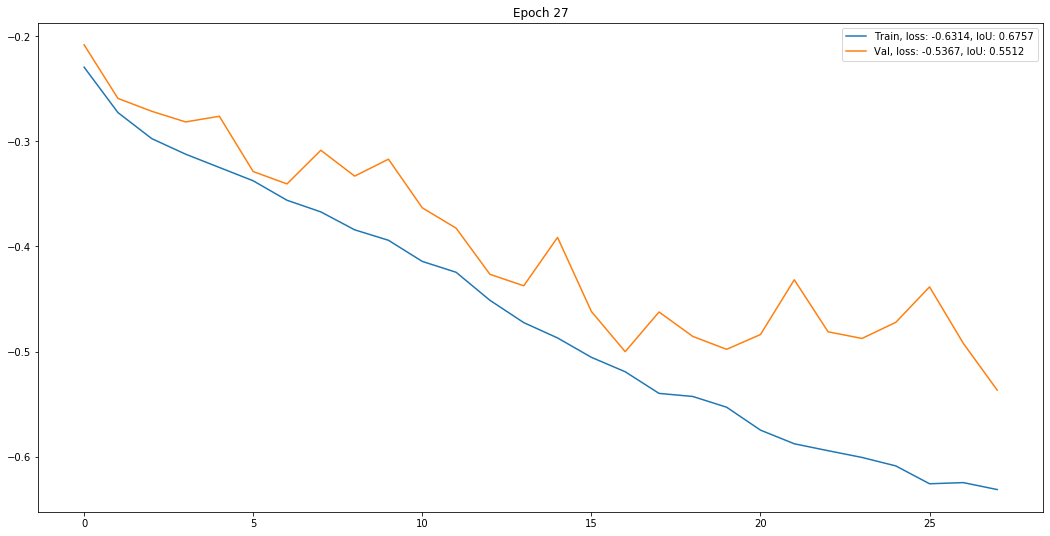

 Epoch: 28 of 70, Iter.: 44 of 44, Loss: -0.636668, Val. Loss: -0.587390
 Epoch: 28 of 70, Iter.: 44 of 44, IoU: 0.674715, Val. IoU: 0.616370


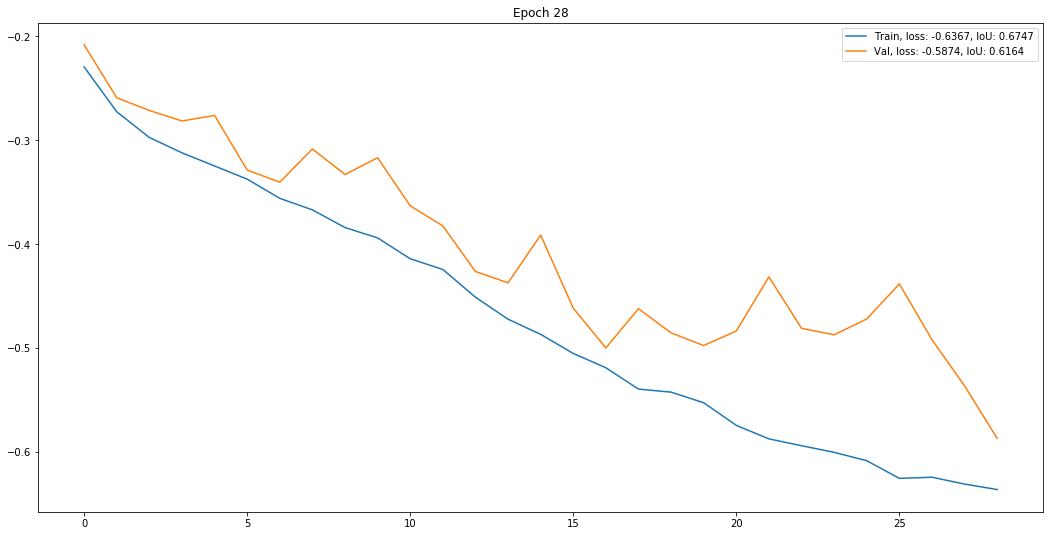

 Epoch: 29 of 70, Iter.: 44 of 44, Loss: -0.626456, Val. Loss: -0.531274
 Epoch: 29 of 70, Iter.: 44 of 44, IoU: 0.668020, Val. IoU: 0.560838


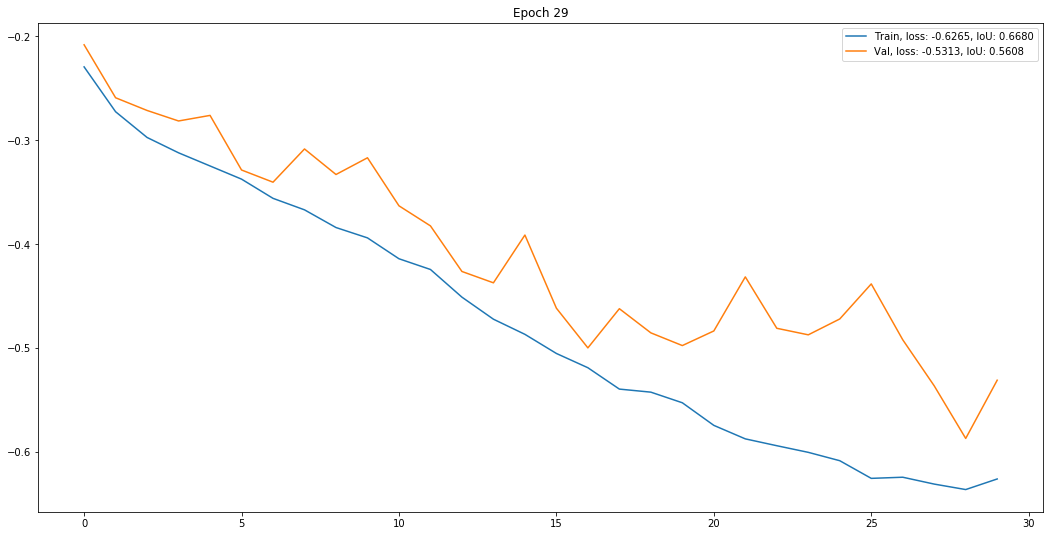

 Epoch: 30 of 70, Iter.: 44 of 44, Loss: -0.645701, Val. Loss: -0.604005
 Epoch: 30 of 70, Iter.: 44 of 44, IoU: 0.681788, Val. IoU: 0.629946


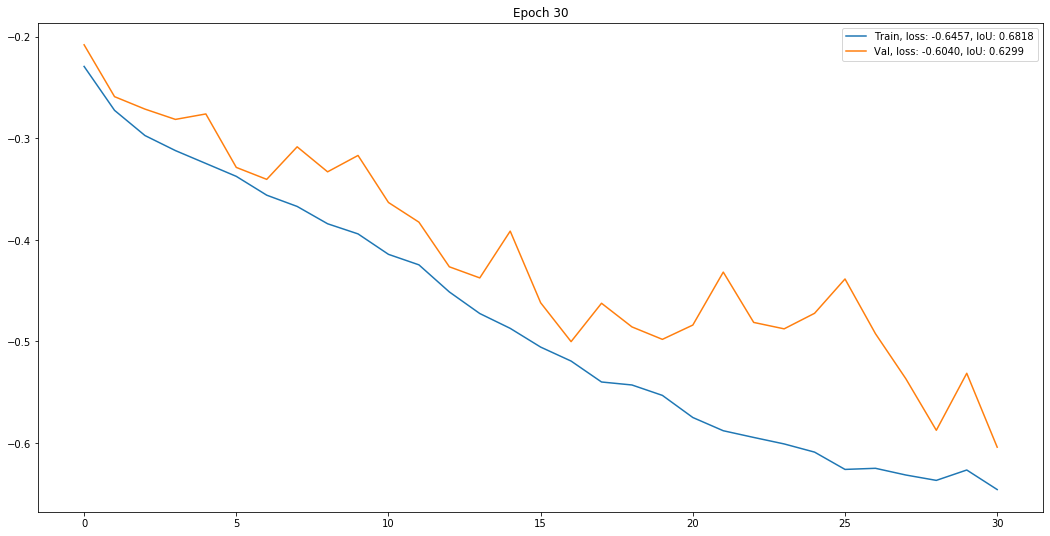

 Epoch: 31 of 70, Iter.: 44 of 44, Loss: -0.661375, Val. Loss: -0.617948
 Epoch: 31 of 70, Iter.: 44 of 44, IoU: 0.698700, Val. IoU: 0.638347


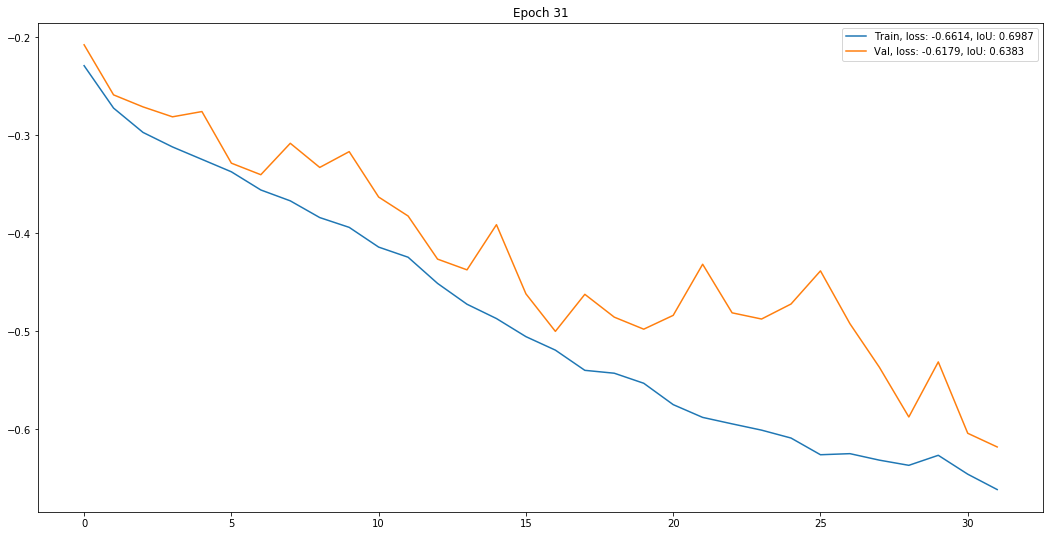

 Epoch: 32 of 70, Iter.: 44 of 44, Loss: -0.665338, Val. Loss: -0.557264
 Epoch: 32 of 70, Iter.: 44 of 44, IoU: 0.698673, Val. IoU: 0.581678


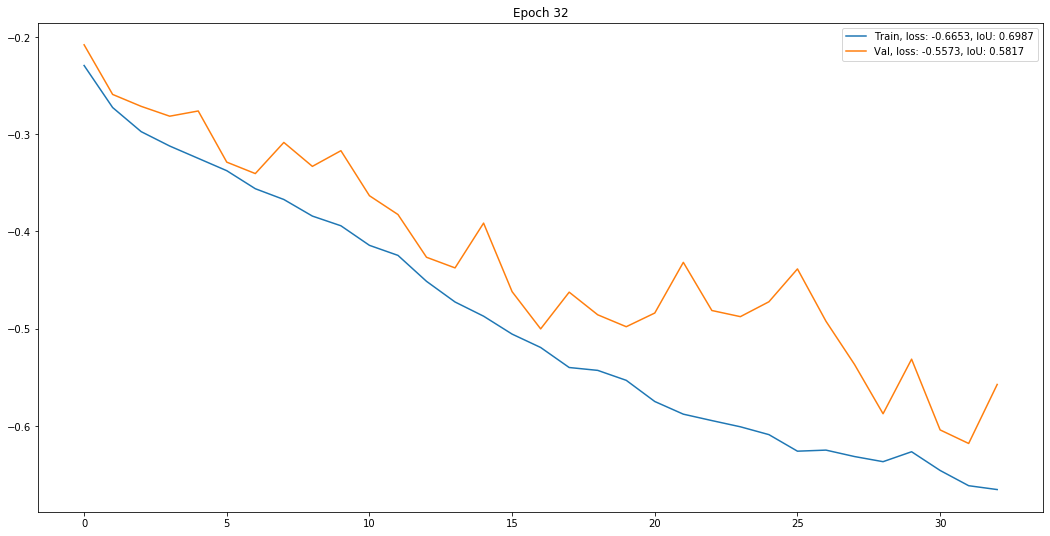

 Epoch: 33 of 70, Iter.: 44 of 44, Loss: -0.672237, Val. Loss: -0.559585
 Epoch: 33 of 70, Iter.: 44 of 44, IoU: 0.703769, Val. IoU: 0.601561


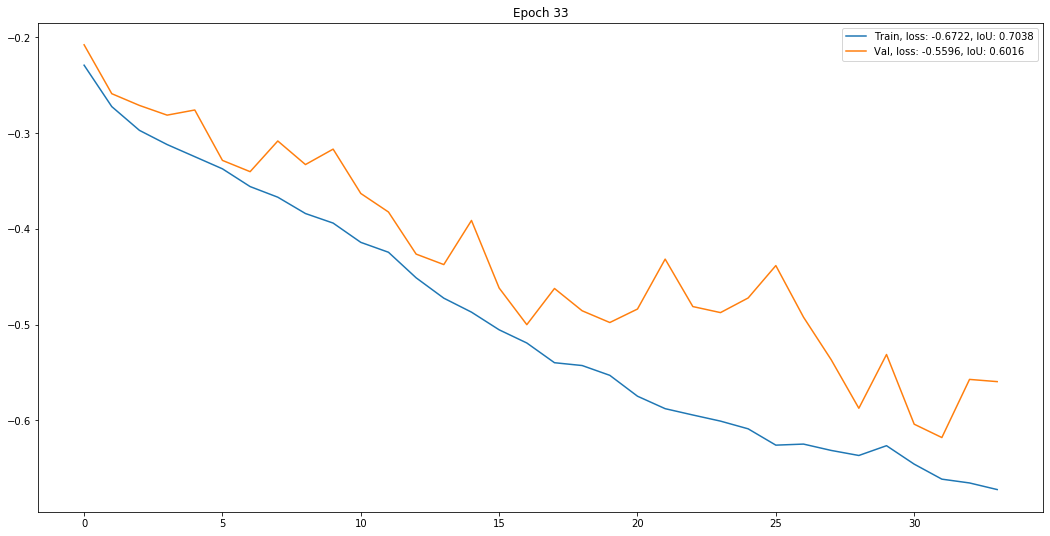

 Epoch: 34 of 70, Iter.: 44 of 44, Loss: -0.669404, Val. Loss: -0.605674
 Epoch: 34 of 70, Iter.: 44 of 44, IoU: 0.704273, Val. IoU: 0.628543


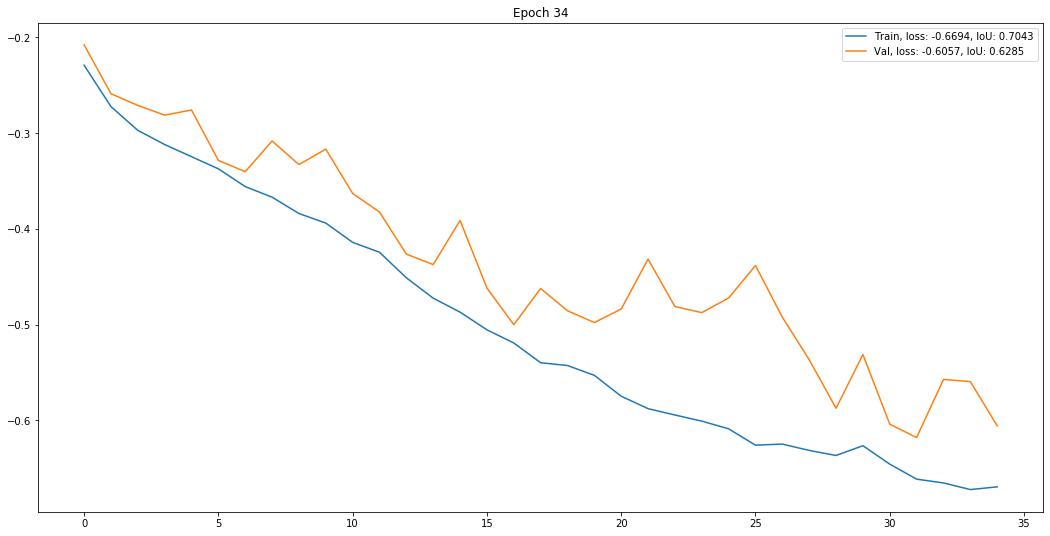

 Epoch: 35 of 70, Iter.: 44 of 44, Loss: -0.677203, Val. Loss: -0.588752
 Epoch: 35 of 70, Iter.: 44 of 44, IoU: 0.708101, Val. IoU: 0.614690


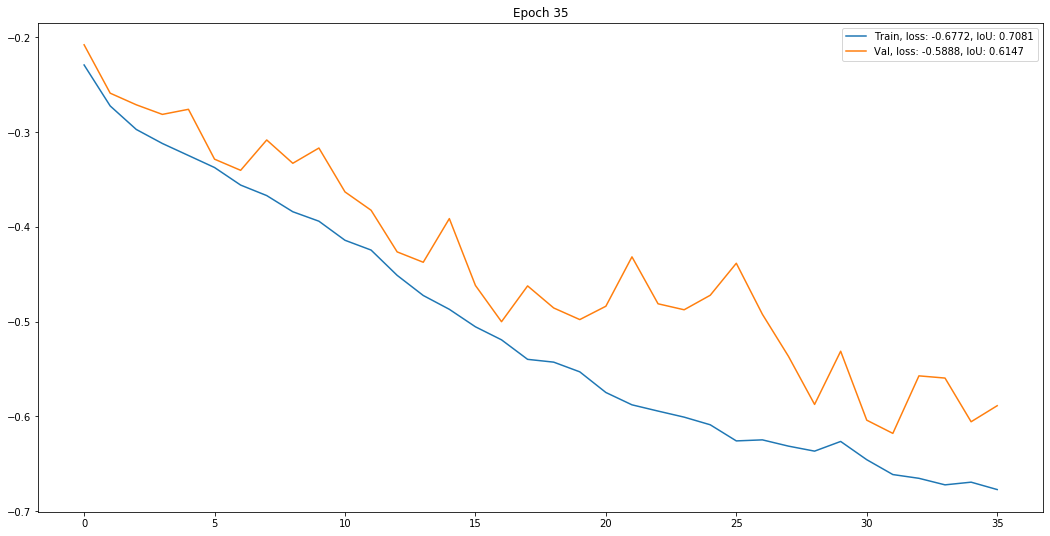

 Epoch: 36 of 70, Iter.: 44 of 44, Loss: -0.682951, Val. Loss: -0.630926
 Epoch: 36 of 70, Iter.: 44 of 44, IoU: 0.711079, Val. IoU: 0.645018


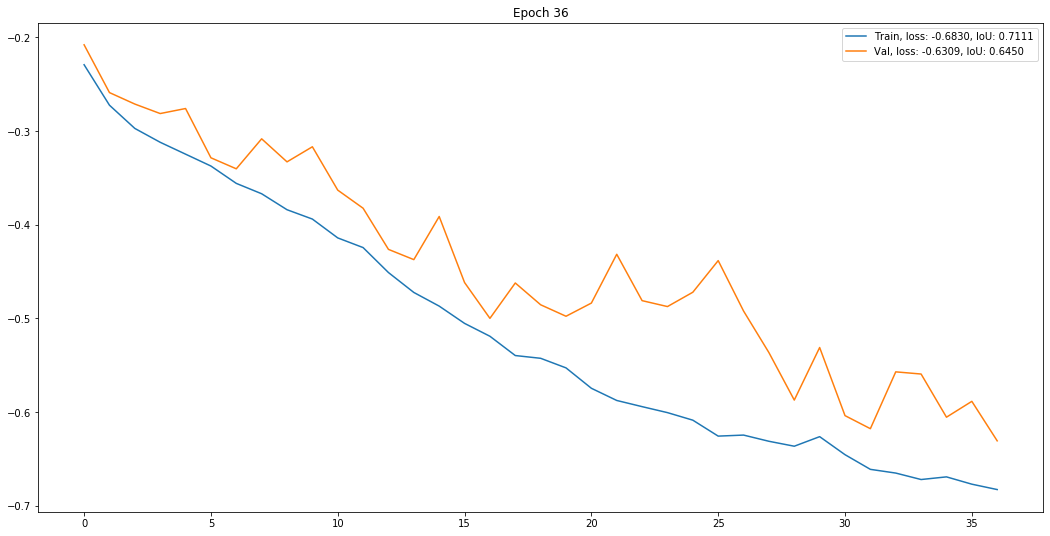

 Epoch: 37 of 70, Iter.: 44 of 44, Loss: -0.684434, Val. Loss: -0.595106
 Epoch: 37 of 70, Iter.: 44 of 44, IoU: 0.714831, Val. IoU: 0.614335


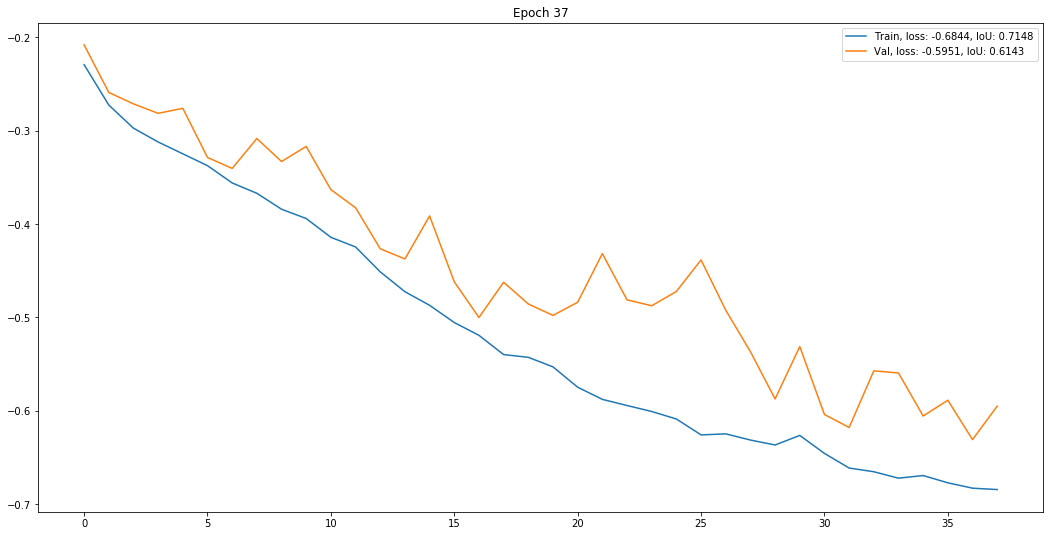

 Epoch: 38 of 70, Iter.: 44 of 44, Loss: -0.678905, Val. Loss: -0.548079
 Epoch: 38 of 70, Iter.: 44 of 44, IoU: 0.707823, Val. IoU: 0.580807


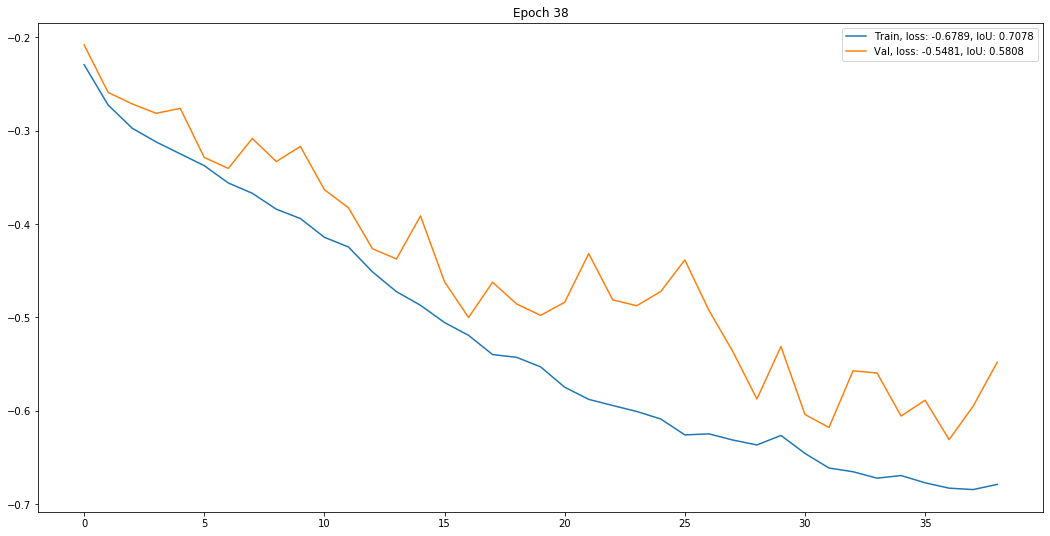

 Epoch: 39 of 70, Iter.: 44 of 44, Loss: -0.693002, Val. Loss: -0.593114
 Epoch: 39 of 70, Iter.: 44 of 44, IoU: 0.718143, Val. IoU: 0.610731


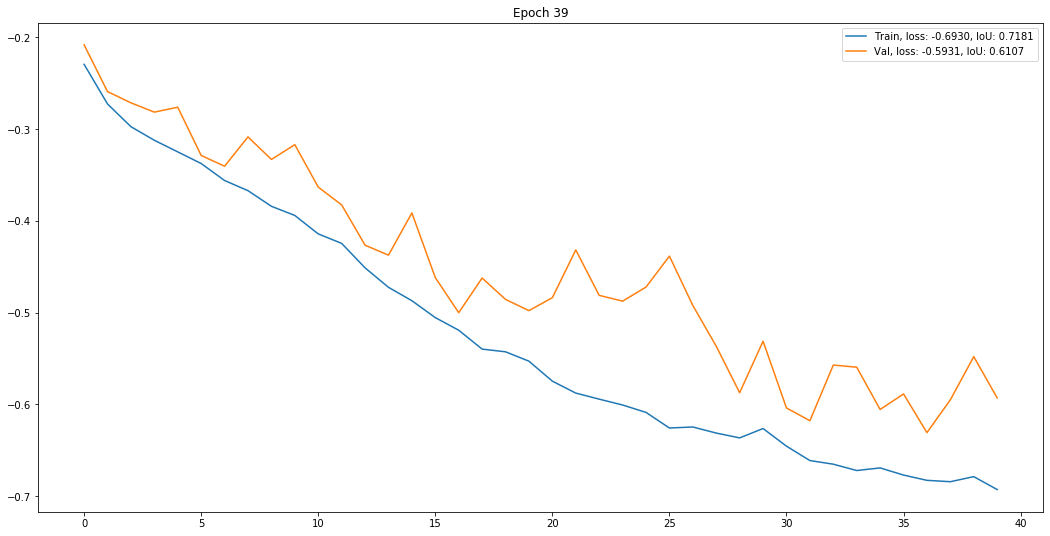

 Epoch: 40 of 70, Iter.: 44 of 44, Loss: -0.684780, Val. Loss: -0.619283
 Epoch: 40 of 70, Iter.: 44 of 44, IoU: 0.708227, Val. IoU: 0.644408


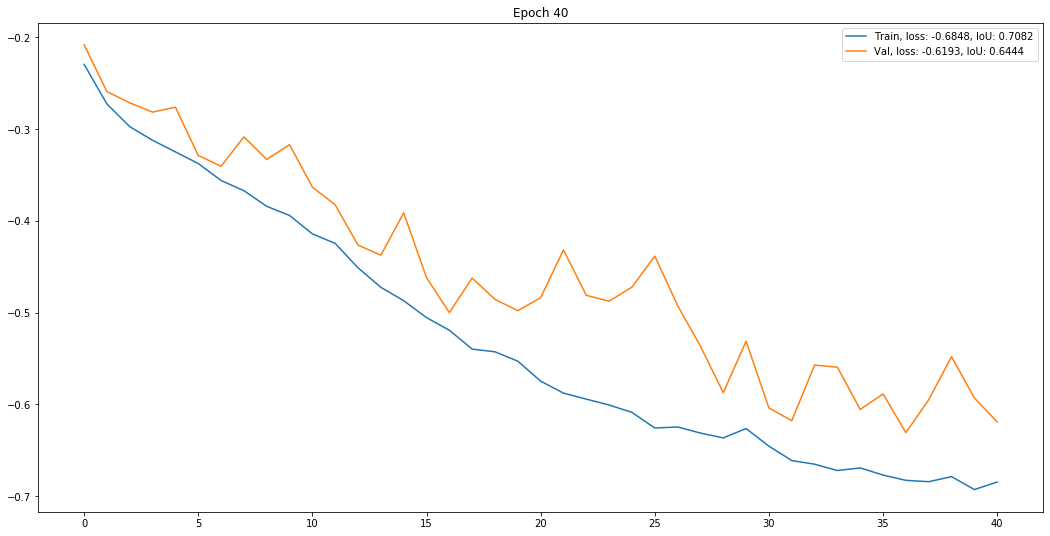

 Epoch: 41 of 70, Iter.: 44 of 44, Loss: -0.696530, Val. Loss: -0.539216
 Epoch: 41 of 70, Iter.: 44 of 44, IoU: 0.721924, Val. IoU: 0.559605


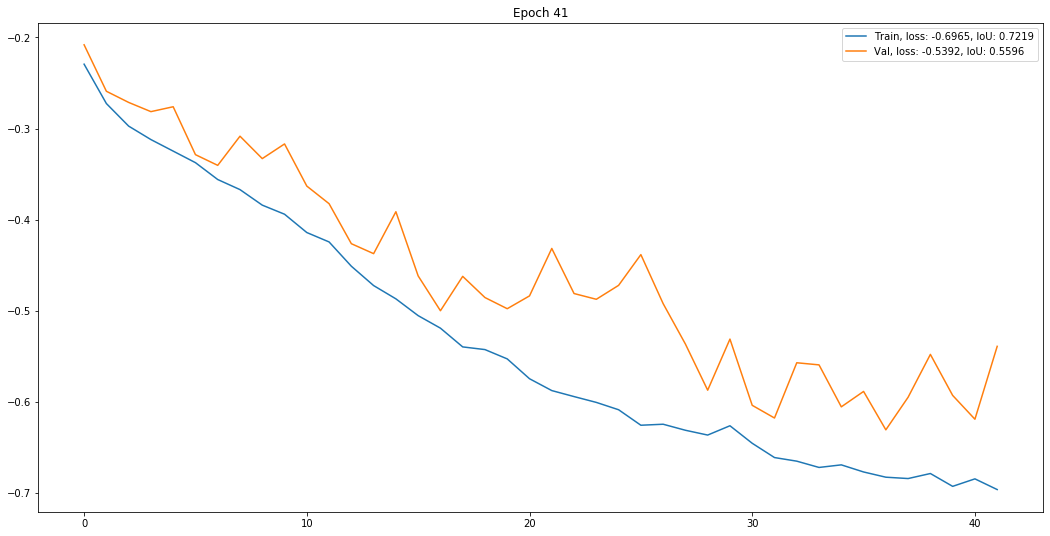

 Epoch: 42 of 70, Iter.: 44 of 44, Loss: -0.695814, Val. Loss: -0.586930
 Epoch: 42 of 70, Iter.: 44 of 44, IoU: 0.718458, Val. IoU: 0.610702


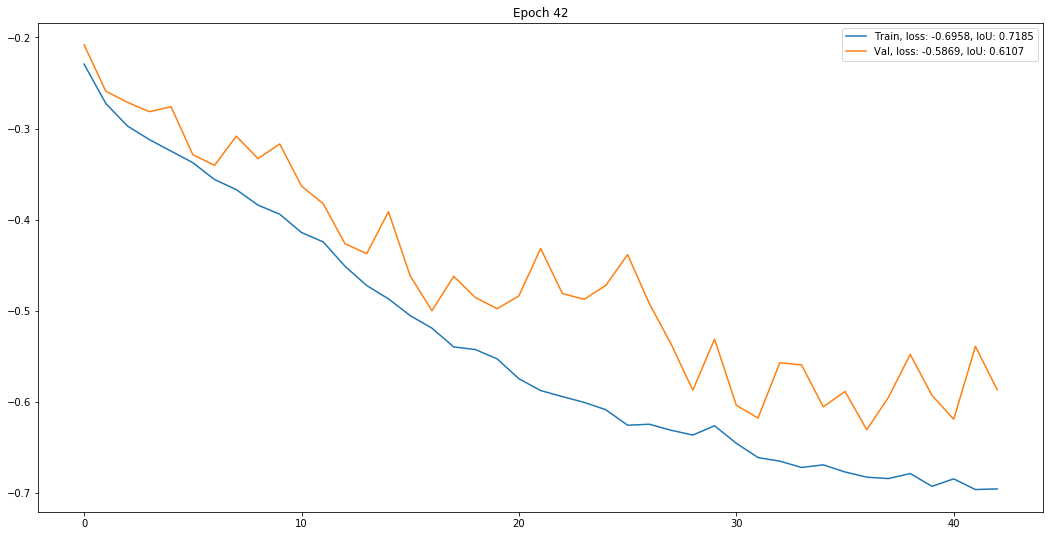

 Epoch: 43 of 70, Iter.: 44 of 44, Loss: -0.701734, Val. Loss: -0.607493
 Epoch: 43 of 70, Iter.: 44 of 44, IoU: 0.722519, Val. IoU: 0.633374


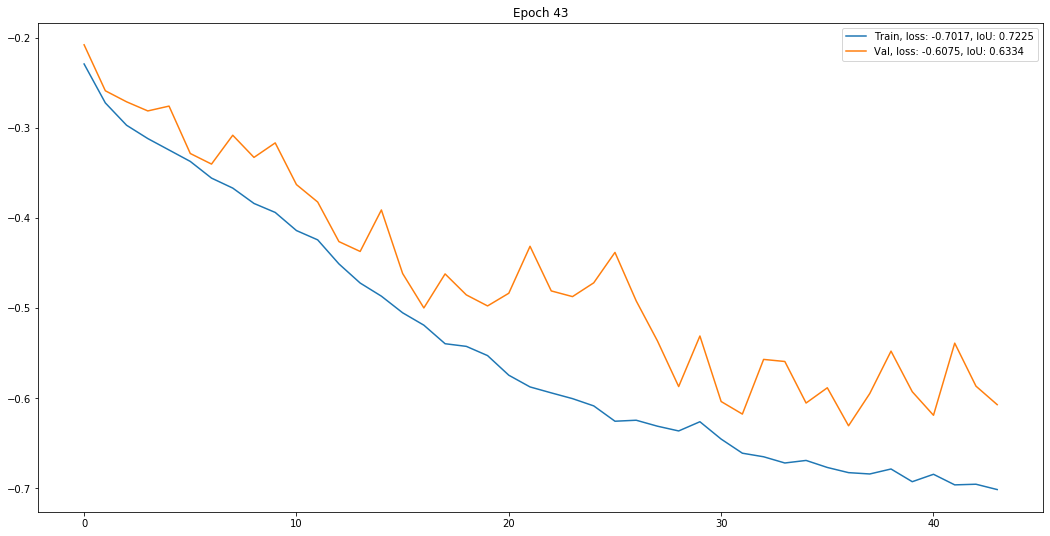

 Epoch: 44 of 70, Iter.: 44 of 44, Loss: -0.704212, Val. Loss: -0.630265
 Epoch: 44 of 70, Iter.: 44 of 44, IoU: 0.726487, Val. IoU: 0.662168


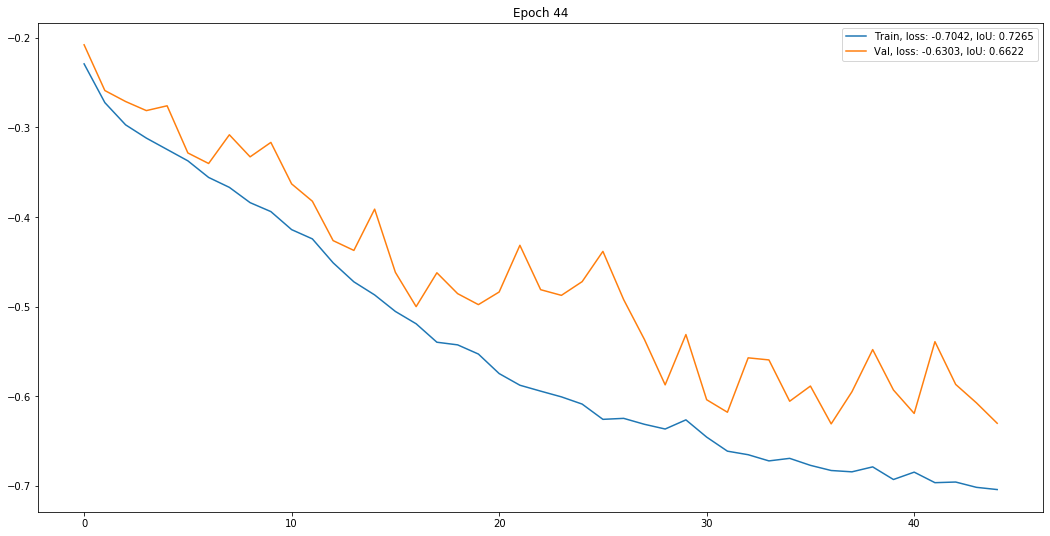

 Epoch: 45 of 70, Iter.: 44 of 44, Loss: -0.707533, Val. Loss: -0.632055
 Epoch: 45 of 70, Iter.: 44 of 44, IoU: 0.730111, Val. IoU: 0.652995


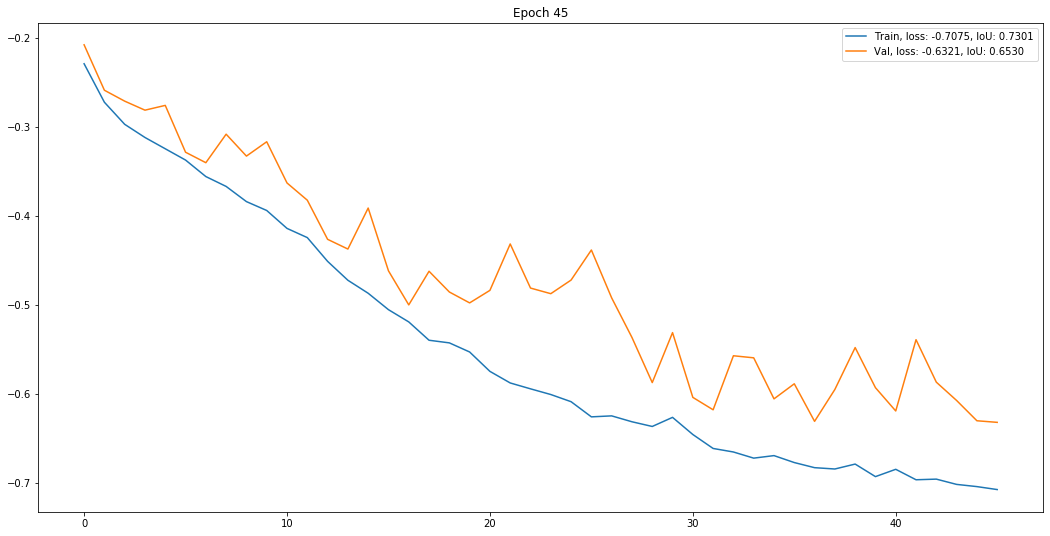

 Epoch: 46 of 70, Iter.: 44 of 44, Loss: -0.714008, Val. Loss: -0.648812
 Epoch: 46 of 70, Iter.: 44 of 44, IoU: 0.735826, Val. IoU: 0.673134


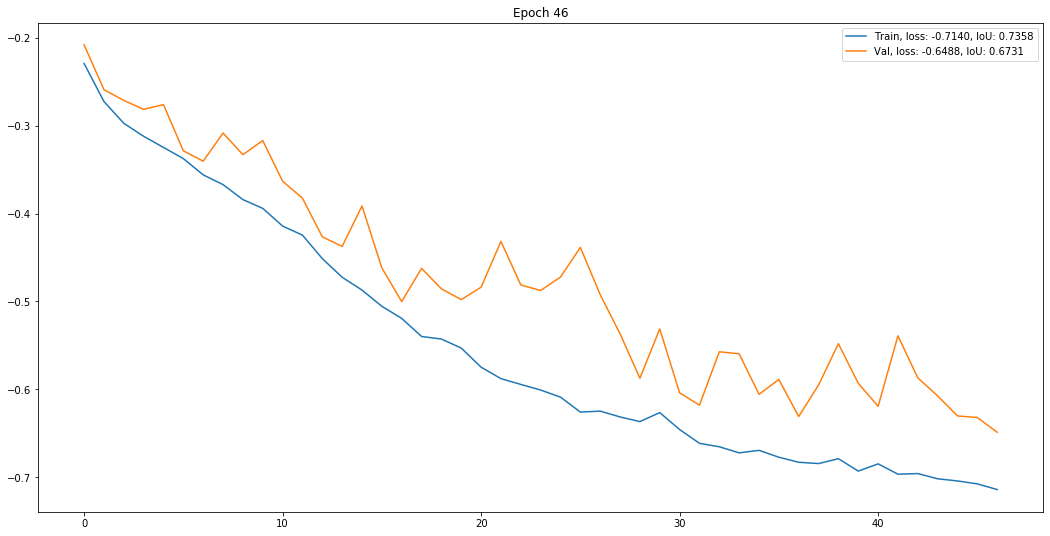

 Epoch: 47 of 70, Iter.: 44 of 44, Loss: -0.716765, Val. Loss: -0.659918
 Epoch: 47 of 70, Iter.: 44 of 44, IoU: 0.735143, Val. IoU: 0.683617


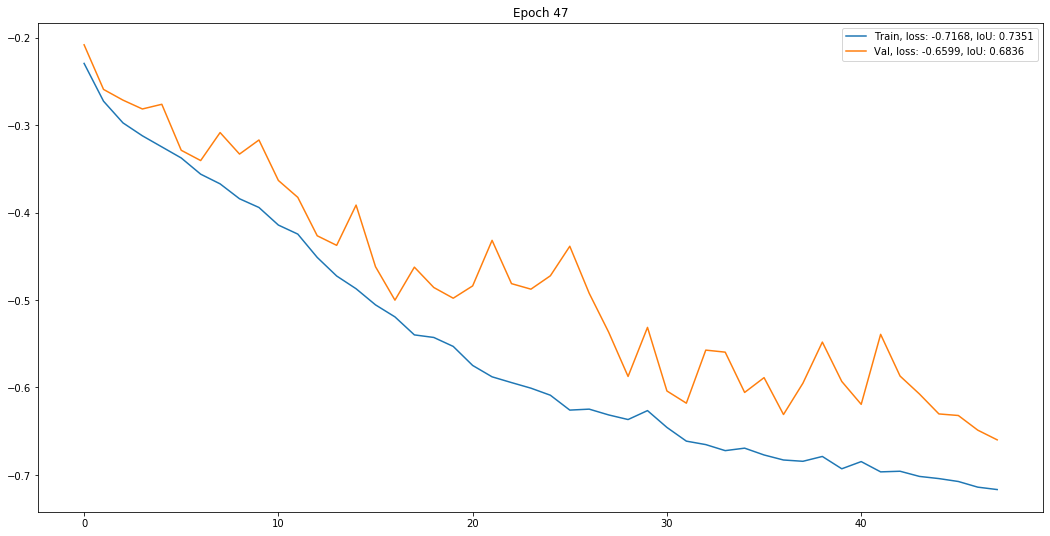

 Epoch: 48 of 70, Iter.: 44 of 44, Loss: -0.711740, Val. Loss: -0.648213
 Epoch: 48 of 70, Iter.: 44 of 44, IoU: 0.732443, Val. IoU: 0.661234


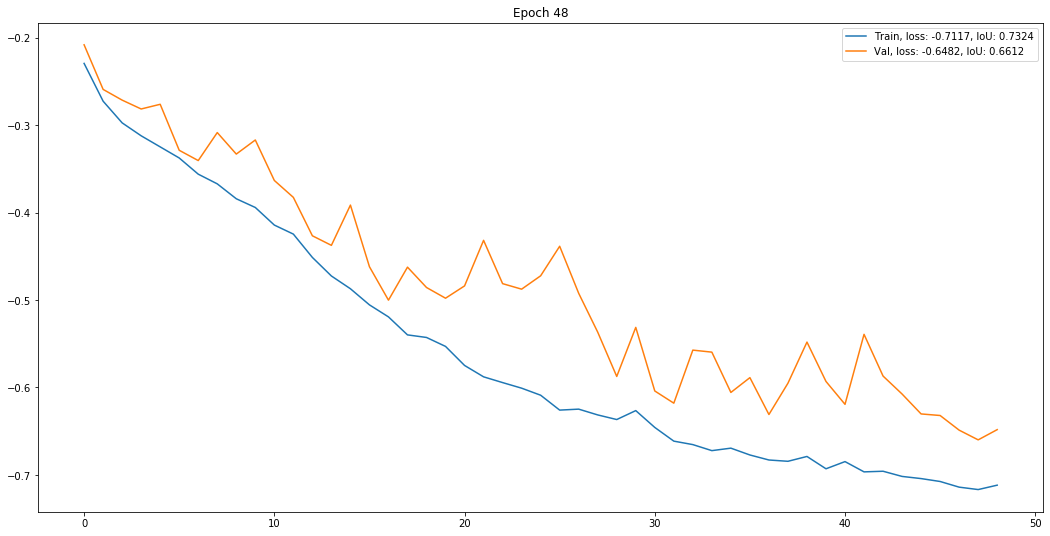

 Epoch: 49 of 70, Iter.: 44 of 44, Loss: -0.709407, Val. Loss: -0.620496
 Epoch: 49 of 70, Iter.: 44 of 44, IoU: 0.727852, Val. IoU: 0.625619


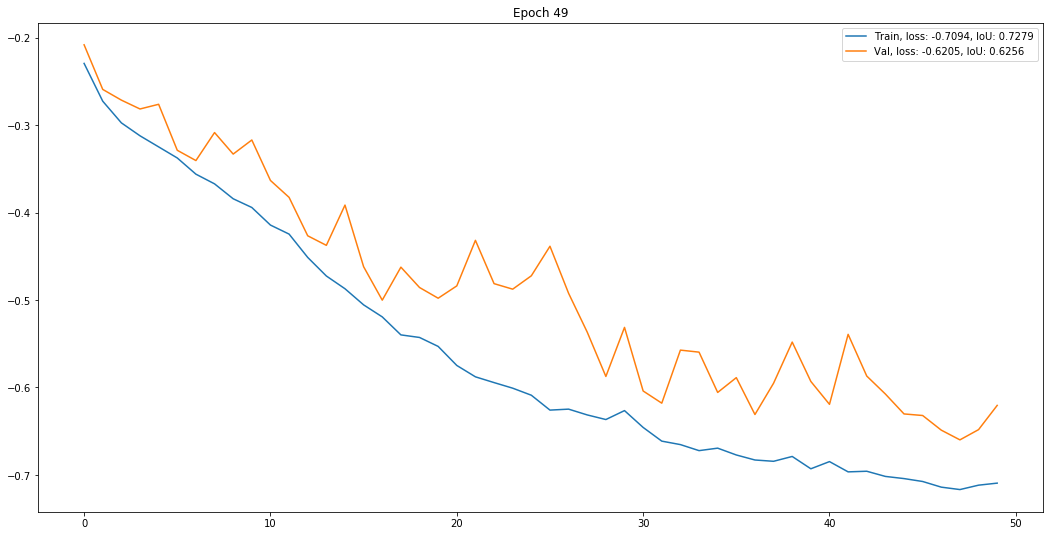

 Epoch: 50 of 70, Iter.: 44 of 44, Loss: -0.715377, Val. Loss: -0.662522
 Epoch: 50 of 70, Iter.: 44 of 44, IoU: 0.738447, Val. IoU: 0.697930


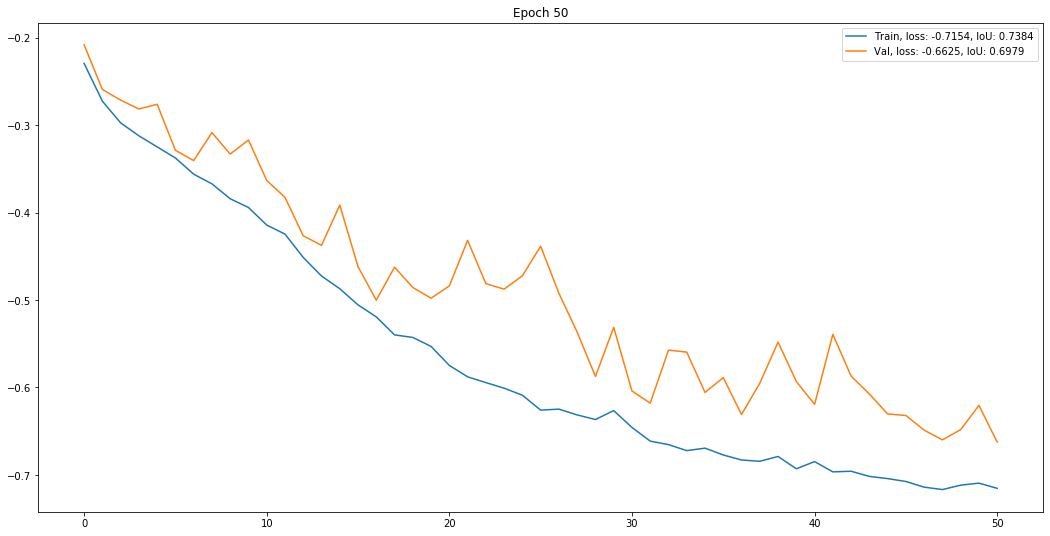

 Epoch: 51 of 70, Iter.: 44 of 44, Loss: -0.713843, Val. Loss: -0.620828
 Epoch: 51 of 70, Iter.: 44 of 44, IoU: 0.736684, Val. IoU: 0.632906


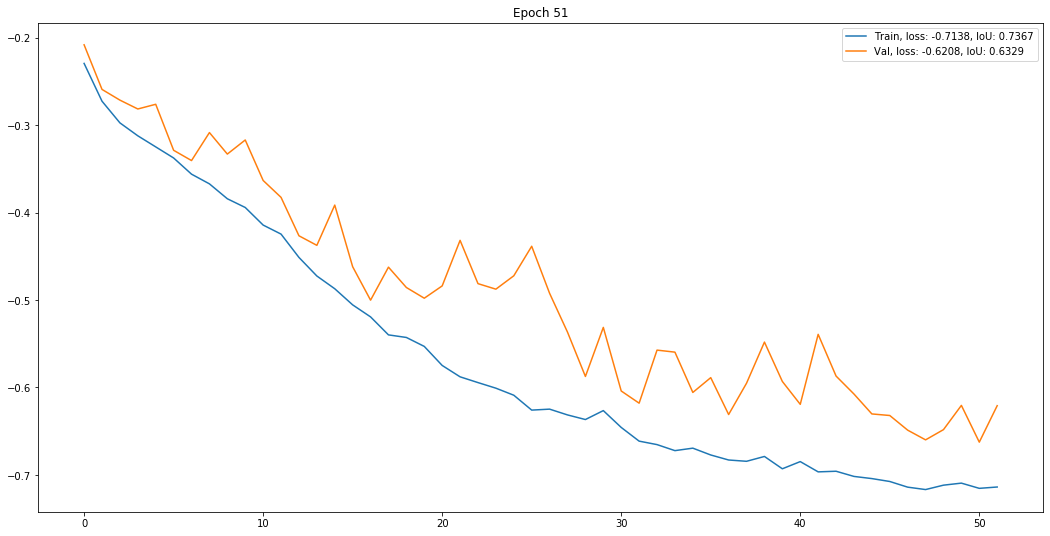

 Epoch: 52 of 70, Iter.: 44 of 44, Loss: -0.723263, Val. Loss: -0.602329
 Epoch: 52 of 70, Iter.: 44 of 44, IoU: 0.738577, Val. IoU: 0.616299


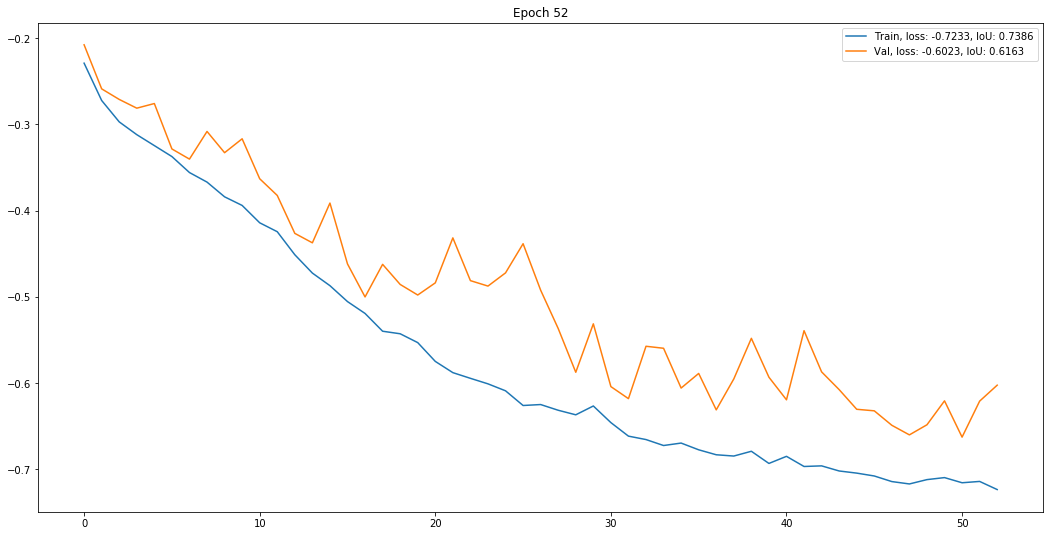

 Epoch: 53 of 70, Iter.: 44 of 44, Loss: -0.731722, Val. Loss: -0.659474
 Epoch: 53 of 70, Iter.: 44 of 44, IoU: 0.746091, Val. IoU: 0.661716


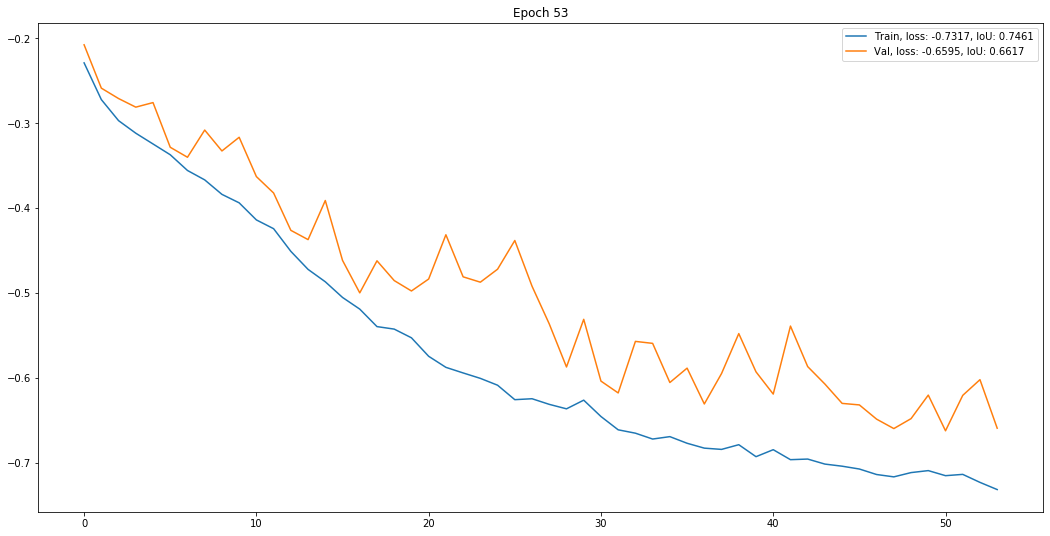

 Epoch: 54 of 70, Iter.: 44 of 44, Loss: -0.731471, Val. Loss: -0.676689
 Epoch: 54 of 70, Iter.: 44 of 44, IoU: 0.745192, Val. IoU: 0.680735


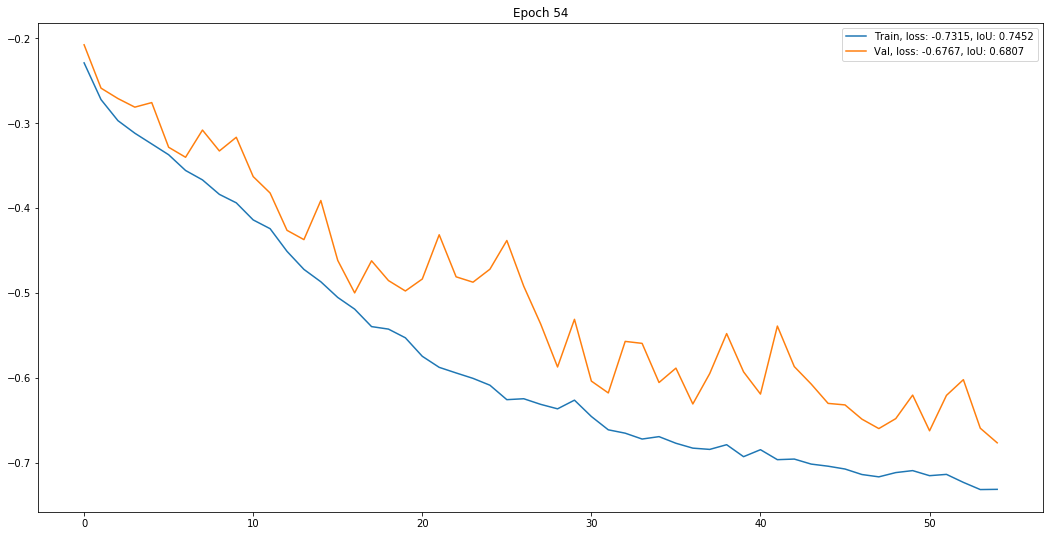

 Epoch: 55 of 70, Iter.: 44 of 44, Loss: -0.719847, Val. Loss: -0.663794
 Epoch: 55 of 70, Iter.: 44 of 44, IoU: 0.737501, Val. IoU: 0.670192


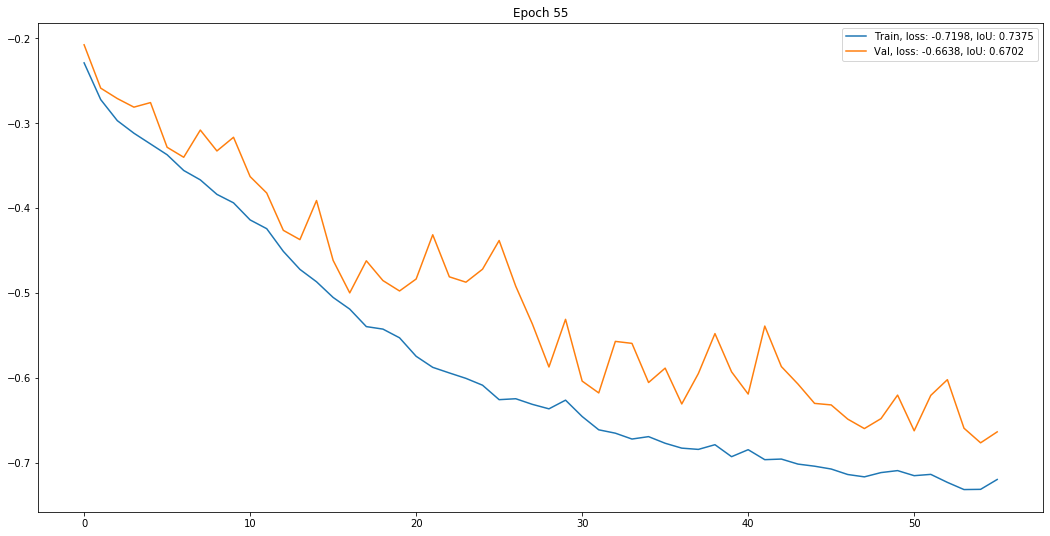

 Epoch: 56 of 70, Iter.: 44 of 44, Loss: -0.726950, Val. Loss: -0.665806
 Epoch: 56 of 70, Iter.: 44 of 44, IoU: 0.740148, Val. IoU: 0.672420


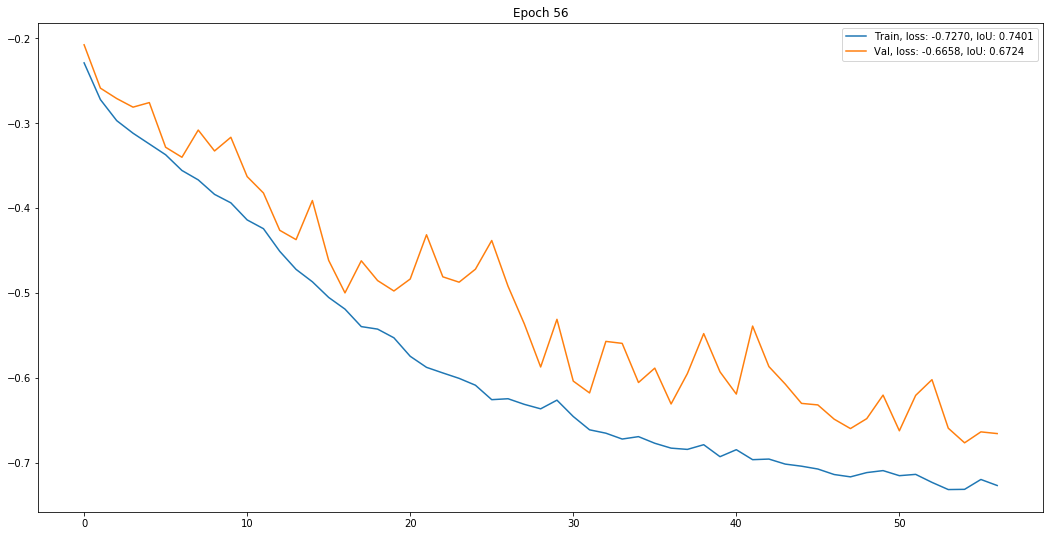

 Epoch: 57 of 70, Iter.: 44 of 44, Loss: -0.729181, Val. Loss: -0.649659
 Epoch: 57 of 70, Iter.: 44 of 44, IoU: 0.741880, Val. IoU: 0.669163


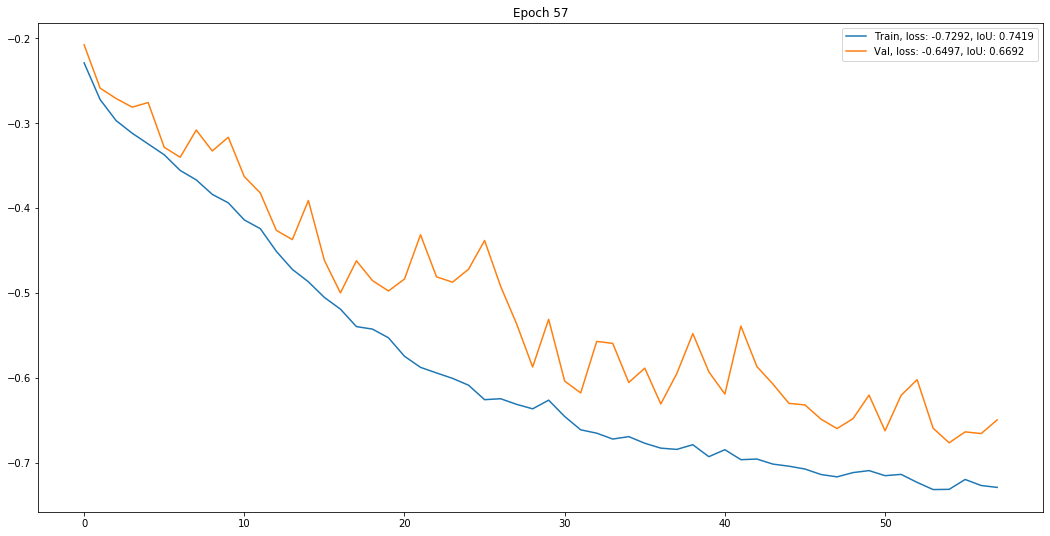

 Epoch: 58 of 70, Iter.: 44 of 44, Loss: -0.740861, Val. Loss: -0.681794
 Epoch: 58 of 70, Iter.: 44 of 44, IoU: 0.752608, Val. IoU: 0.703143


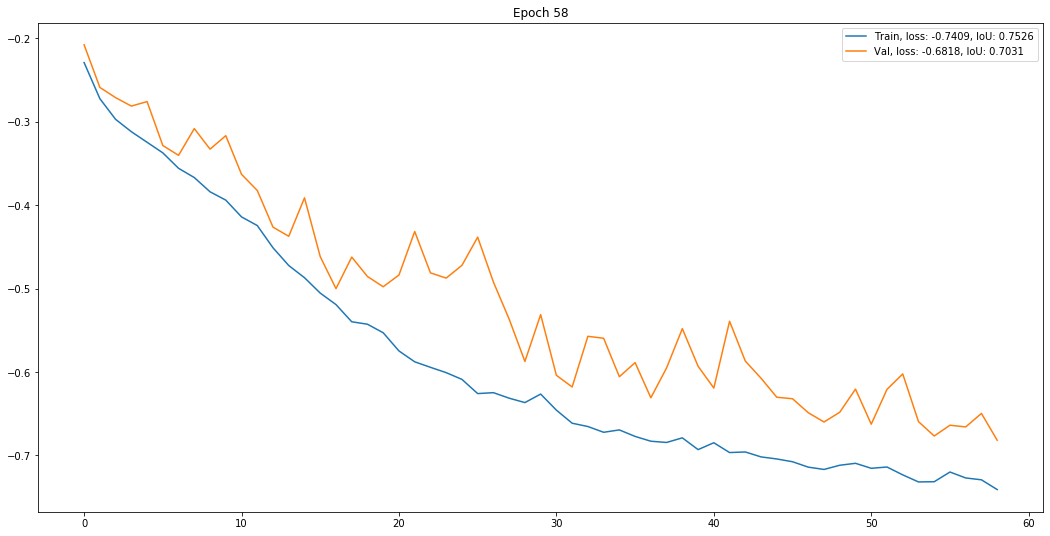

 Epoch: 59 of 70, Iter.: 44 of 44, Loss: -0.739864, Val. Loss: -0.664482
 Epoch: 59 of 70, Iter.: 44 of 44, IoU: 0.752654, Val. IoU: 0.689538


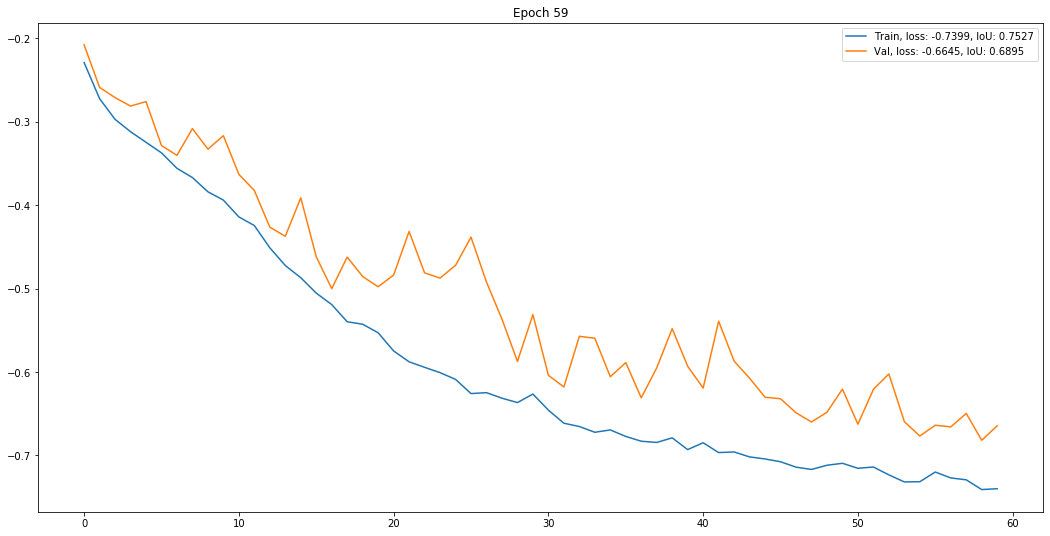

 Epoch: 60 of 70, Iter.: 44 of 44, Loss: -0.733752, Val. Loss: -0.664991
 Epoch: 60 of 70, Iter.: 44 of 44, IoU: 0.753104, Val. IoU: 0.675710


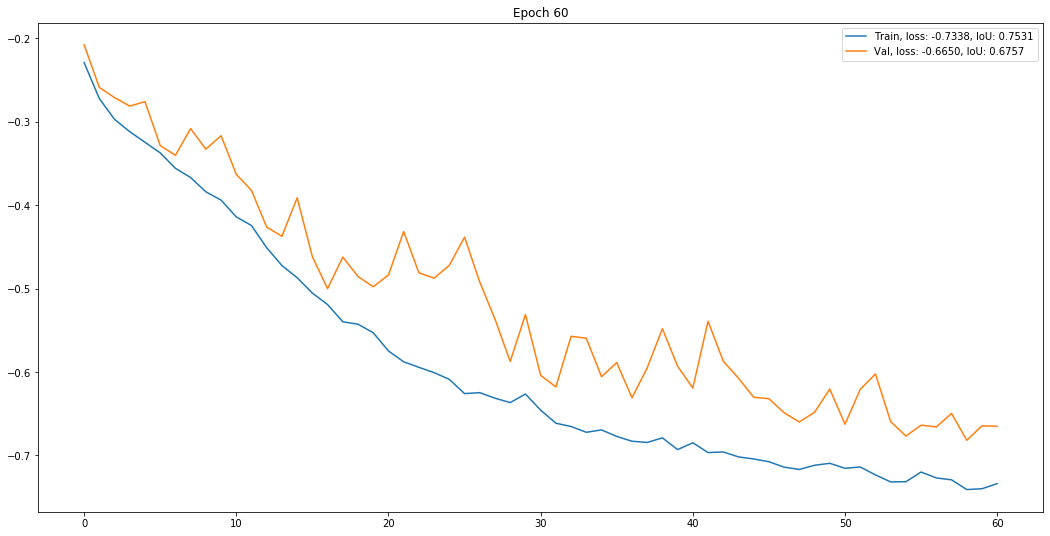

 Epoch: 61 of 70, Iter.: 44 of 44, Loss: -0.743131, Val. Loss: -0.642001
 Epoch: 61 of 70, Iter.: 44 of 44, IoU: 0.752896, Val. IoU: 0.662162


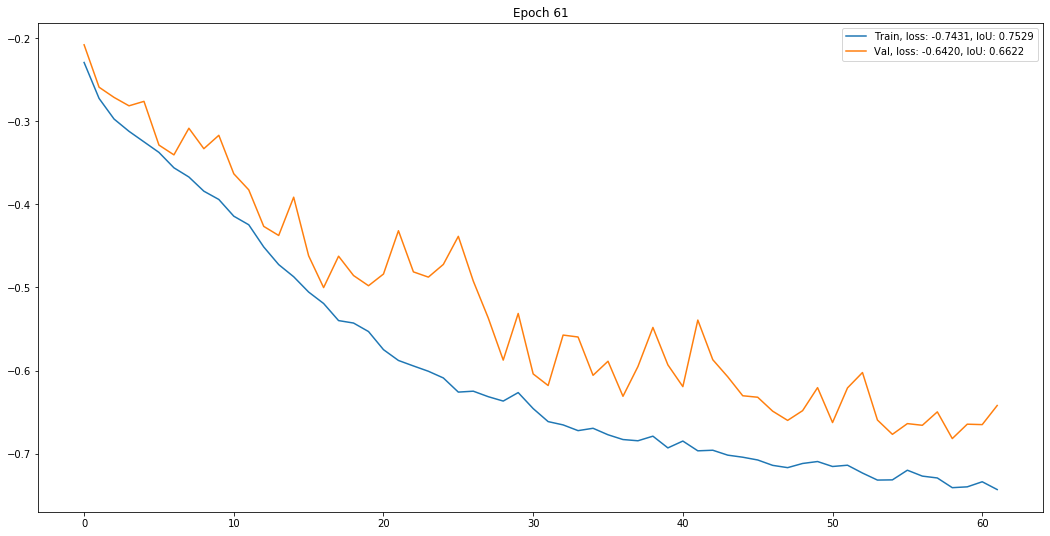

 Epoch: 62 of 70, Iter.: 44 of 44, Loss: -0.748044, Val. Loss: -0.672055
 Epoch: 62 of 70, Iter.: 44 of 44, IoU: 0.760562, Val. IoU: 0.682790


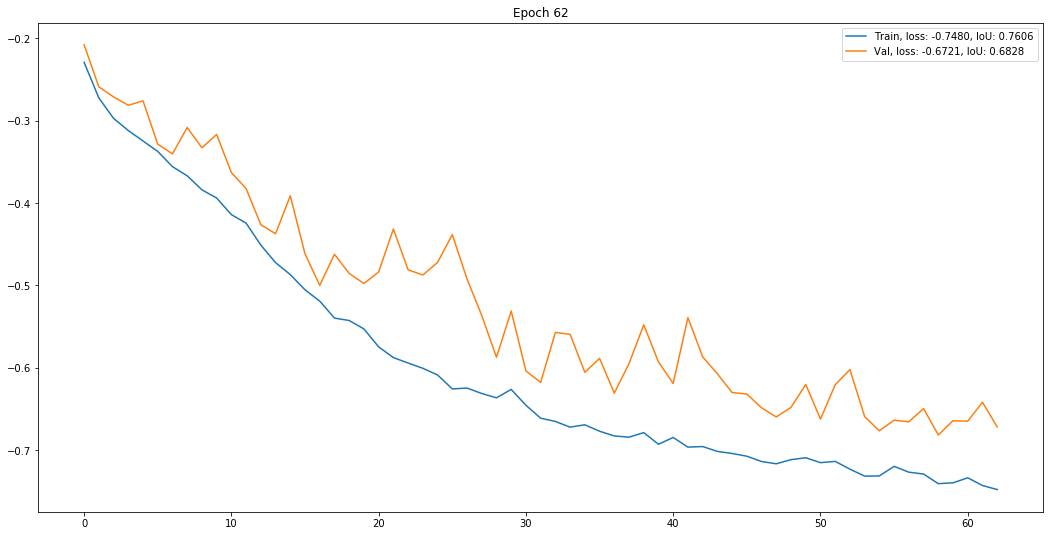

 Epoch: 63 of 70, Iter.: 44 of 44, Loss: -0.746570, Val. Loss: -0.662635
 Epoch: 63 of 70, Iter.: 44 of 44, IoU: 0.755404, Val. IoU: 0.676550


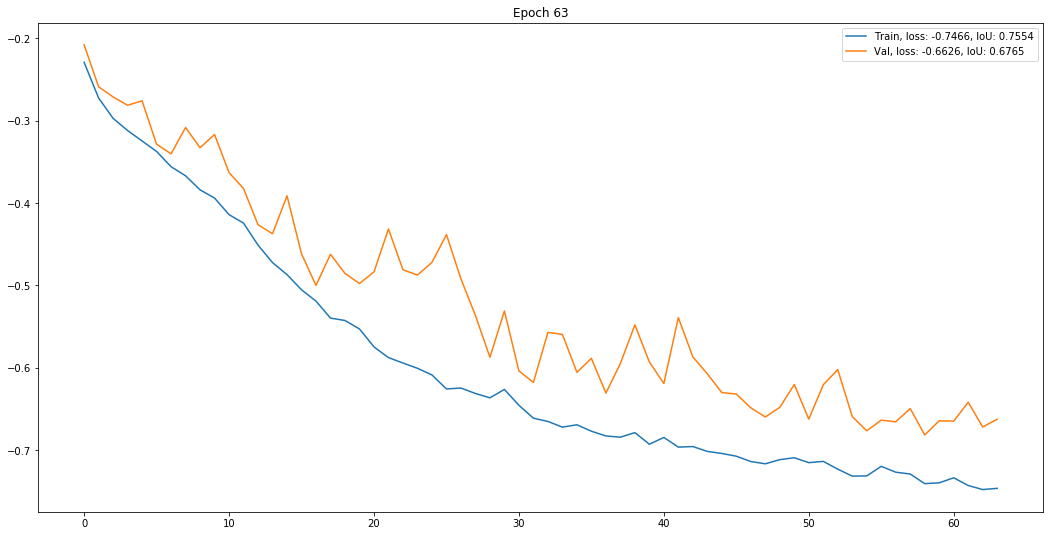

 Epoch: 64 of 70, Iter.: 44 of 44, Loss: -0.750744, Val. Loss: -0.645193
 Epoch: 64 of 70, Iter.: 44 of 44, IoU: 0.757389, Val. IoU: 0.662881


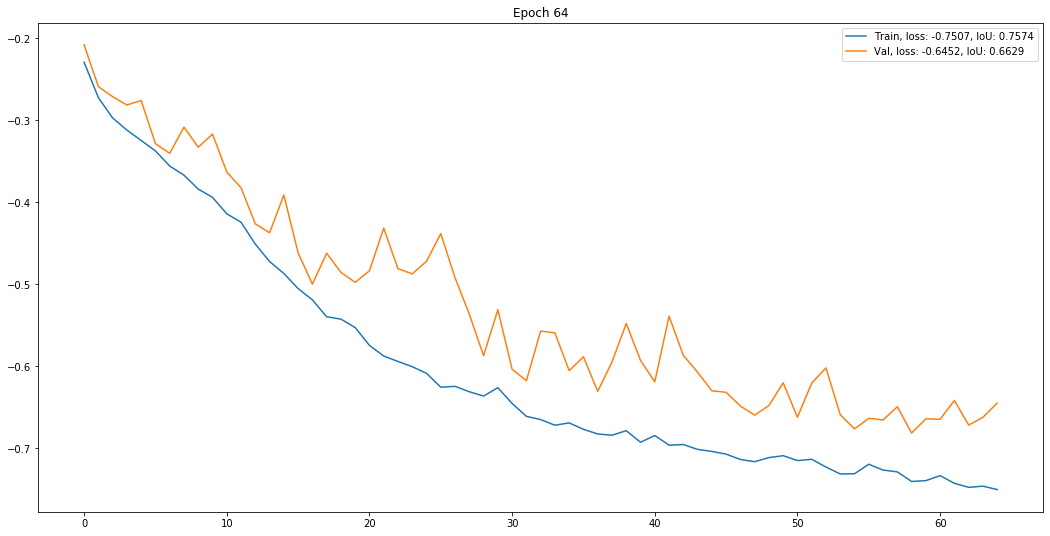

 Epoch: 65 of 70, Iter.: 44 of 44, Loss: -0.741771, Val. Loss: -0.677610
 Epoch: 65 of 70, Iter.: 44 of 44, IoU: 0.755128, Val. IoU: 0.689002


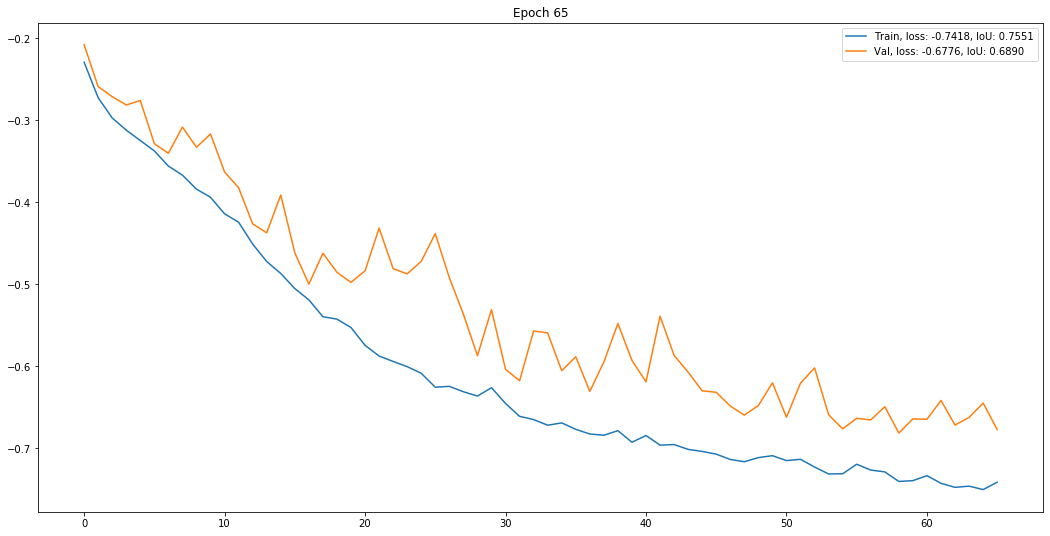

 Epoch: 66 of 70, Iter.: 44 of 44, Loss: -0.745850, Val. Loss: -0.686475
 Epoch: 66 of 70, Iter.: 44 of 44, IoU: 0.759297, Val. IoU: 0.700627


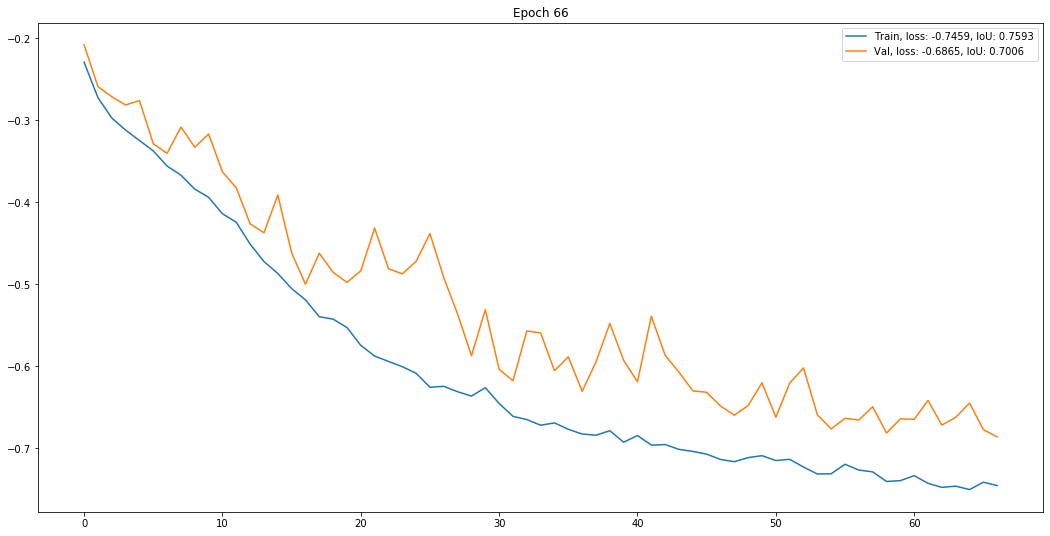

 Epoch: 67 of 70, Iter.: 44 of 44, Loss: -0.754027, Val. Loss: -0.677308
 Epoch: 67 of 70, Iter.: 44 of 44, IoU: 0.761975, Val. IoU: 0.682853


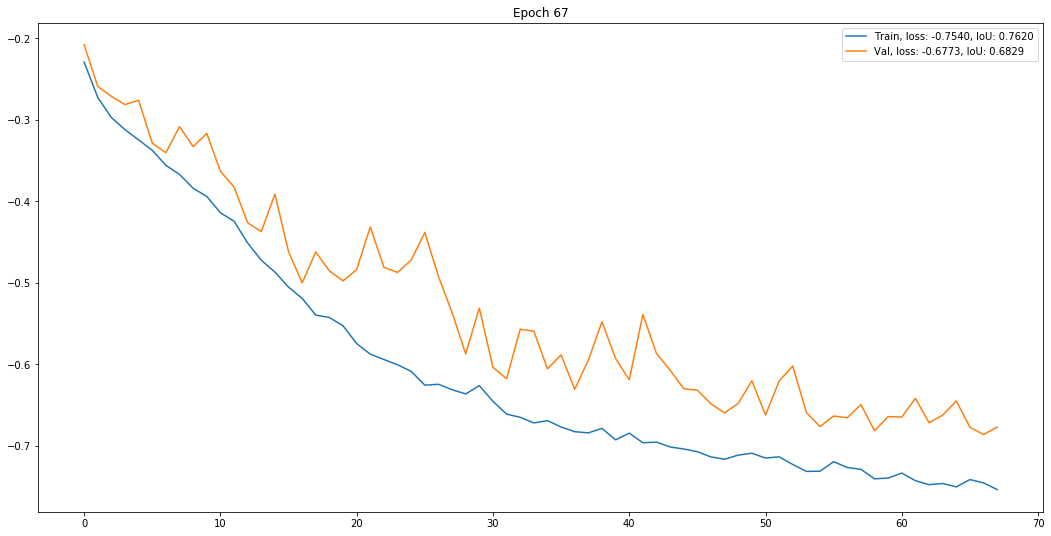

 Epoch: 68 of 70, Iter.: 44 of 44, Loss: -0.758554, Val. Loss: -0.669911
 Epoch: 68 of 70, Iter.: 44 of 44, IoU: 0.765382, Val. IoU: 0.680887


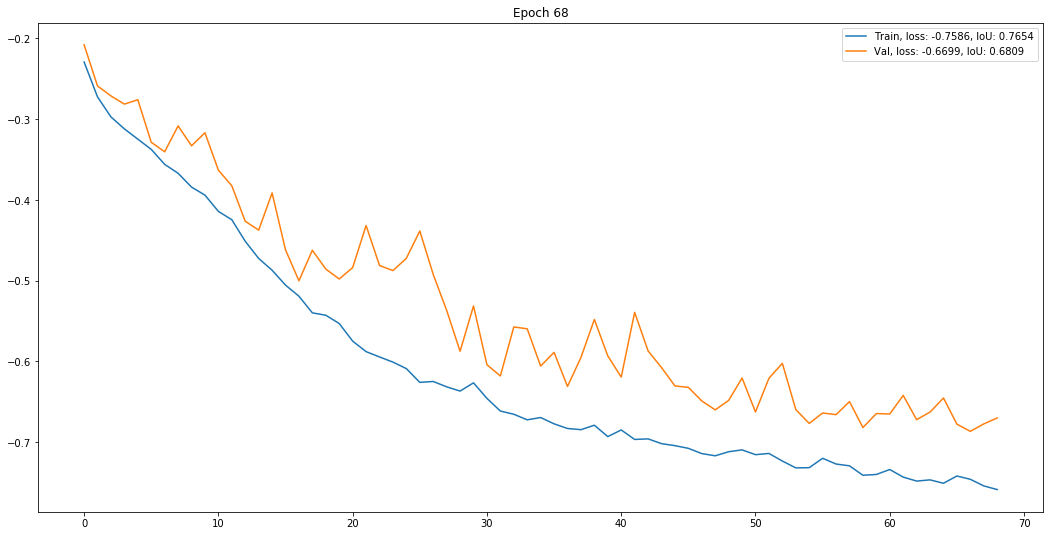

 Epoch: 69 of 70, Iter.: 44 of 44, Loss: -0.751811, Val. Loss: -0.660537
 Epoch: 69 of 70, Iter.: 44 of 44, IoU: 0.760702, Val. IoU: 0.668521


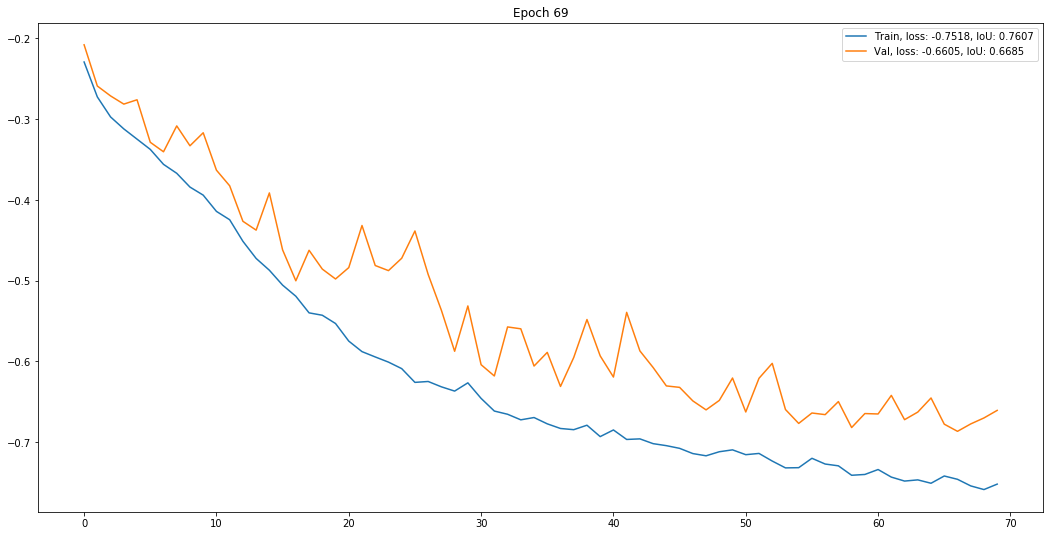

In [22]:
train_losses = []
val_losses = []
best_iou = 0
best_loss = np.Inf
best_epoch = -1


for epoch in range(epochs):
    running_loss = 0
    running_iou = 0
    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimiser.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimiser.step()
        
        running_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1)), end="")
        
        running_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_iou/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss = 0
    val_iou = 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)
    # compute overall epoch iou-s
    epoch_train_iou = running_iou/len(dataloader_train)
    epoch_val_iou = val_iou/len(dataloader_val)
    
    print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_val_loss))
    print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_iou, epoch_val_iou))
    
    
    # plot 
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {epoch_train_loss:.4f}, IoU: {epoch_train_iou:.4f}')
    plt.plot(np.arange(len(val_losses)), val_losses, label=f'Val, loss: {epoch_val_loss:.4f}, IoU: {epoch_val_iou:.4f}')
    plt.title(f'Epoch {epoch}')
    plt.legend(loc='best')
    plt.show()
    
    # save if best results
    best_iou = max(best_iou, epoch_val_iou)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch = epoch if best_iou == epoch_val_iou else best_epoch
    
    if best_epoch == epoch:
        # print('Saving..')
        state = {
            'net': model.state_dict(),
            'iou': best_iou,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, f'../checkpoints/ckpt_{model_name}.pth')

In [23]:
best_epoch, best_iou

(58, tensor(0.7031, device='cuda:0'))

In [24]:
# # Begin training
# model = UNet(channel_in=3, channel_out=1)
# model = model.to(DEVICE)

# train_losses = []
# test_losses = []
# best_iou = 0
# best_epoch = -1

# for epoch in notebook.tqdm(range(30)):
#     train_loss, train_iou = train(model, optimiser, criterion, dataloader_train, epoch, DEVICE)
#     train_losses.append(train_loss)
    
#     test_loss, test_iou = test(model, criterion, dataloader_val, epoch, DEVICE, best_iou, model_name='Unet_BCEWithLogitsLoss')
#     #scheduler.step(test_loss) # not always needed
#     test_losses.append(test_loss)
    
#     best_iou = max(best_iou, test_iou)
#     best_epoch = epoch if best_iou == test_iou else best_epoch

#     clear_output()
    
#     plt.figure(figsize=(18, 9))
#     plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, IoU: {train_iou}%')
#     plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, IoU: {test_iou}%')
#     plt.title(f'Epoch {epoch}')
#     plt.legend(loc='best')
#     plt.show()

## Evaluate validation performance (full sized images)

In [25]:
%ls ../checkpoints

ckpt_UNet_BCEWithLogitsLoss_baseline.pth  ckpt_UNet_IoULoss_augmented.pth
ckpt_UNet_IoUBCELoss_baseline.pth         ckpt_UNet_IoULoss_baseline.pth


In [35]:
# model_name = 'UNet_BCEWithLogitsLoss_augmented'
model_name = 'UNet_IoULoss_augmented'
# model_name = 'UNet_IoUBCELoss_augmented'


# Begin training
model = UNet(channel_in=3, channel_out=1)
model = model.to(DEVICE) # load model to DEVICE

# load best weights and put into the evaluation mode
model.load_state_dict(torch.load(f'../checkpoints/ckpt_{model_name}.pth')['net'])
#model.eval()

# print('Best epoch:', torch.load(f'../checkpoints/ckpt_{model_name}.pth')['epoch'])
# print(f'Validation iou ({_size[0]}x{_size[0]}):', torch.load(f'../checkpoints/ckpt_{model_name}.pth')['iou'])

torchsummary.summary(model, (3, 256, 256), device='cuda') # Runs a basic test of the network. Very useful and clear!

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
            Conv2d-7        [-1, 128, 128, 128]          73,856
       BatchNorm2d-8        [-1, 128, 128, 128]             256
              ReLU-9        [-1, 128, 128, 128]               0
           Conv2d-10        [-1, 128, 128, 128]         147,584
      BatchNorm2d-11        [-1, 128, 128, 128]             256
             ReLU-12        [-1, 128, 128, 128]               0
           Conv2d-13          [-1, 256, 64, 64]         295,168
      BatchNorm2d-14          [-1, 256,

In [36]:
img.shape, img.dtype

(torch.Size([1, 3, 256, 256]), torch.float32)

In [37]:
path_images = "../datasets/train-val/images"
path_masks = "../datasets/train-val/masks"

with open('../2020-MediaEval-Medico-polyp-segmentation-master/kvasir-seg-train-val/val.txt', 'r') as f:
    ids_val = [l.strip()+'.jpg' for l in f]
    
_size = 256, 256
resize = transforms.Resize(_size, interpolation=0)

## Produce predictions Validation Set

In [38]:
%mkdir ../predictions_val

mkdir: cannot create directory ‘../predictions_val’: File exists


In [39]:
PRED_PATH = '../predictions_val'
time_taken = []
ious = []


for name in ids_val:
    path_img = os.path.join(path_images, name)
    path_mask = os.path.join(path_masks, name)
    
    img = imageio.imread(path_img) / 255
    mask = imageio.imread(path_mask)[:, :, 0] / 255
    mask = mask.round() # binarize to 0 or 1 
    
    # record shape to revert to 
    H, W, _ = img.shape
    resize_back = transforms.Resize((H, W), interpolation=0)
    
    # convert to Tensors and fix the dimentions (Pytorch uses the channels in the first dimension)
    img = torch.FloatTensor(np.transpose(img, [2, 0 ,1])).unsqueeze(0) 
    mask_binary = torch.FloatTensor(mask).unsqueeze(0)
    
    # resize for the model
    img, mask = resize(img), resize(mask_binary)
    
    # put on the GPU
    img, mask = img.to(DEVICE), mask.to(DEVICE)
        
    # Start time
    start_time = time.time()
    ## Prediction
    pred = model(img)
    # End timer
    end_time = time.time() - start_time

    time_taken.append(end_time)
    print("{} - {:.10f}".format(name, end_time))
        
    
    # resize back, nearest interpolation, since it's a mask
    pred = resize_back(pred)
    # put on cpu
    pred = pred.cpu()
    # remove channel => BATCH x H x W
    pred = pred.squeeze(0)
    
    
    # sigmoid, threshold, record score
    ious.append(iou_pytorch_test(pred, mask_binary).item())    
    
    
    # comment out if your model contains a sigmoid or equivalent activation layer
    pred = torch.sigmoid(pred)
    # thresholding since that's how we will make predictions on new imputs
    pred = pred > 0.5 
    # remove BATCH => H x W
    pred = pred.squeeze(0)
    # converto to correct type
    pred = pred.numpy().astype(np.float32)
    # revert to standard intensities
    pred = pred * 255.0
    # save
    pred_path = os.path.join(PRED_PATH, name)
    cv2.imwrite(pred_path, pred)


mean_time_taken = np.mean(time_taken)
mean_fps = 1/mean_time_taken
print("\nMean FPS: ", mean_fps)

mean_iou = np.mean(ious)
print("Mean IoU: ", mean_iou)

cju0s690hkp960855tjuaqvv0.jpg - 0.0065321922
cju0sr5ghl0nd08789uzf1raf.jpg - 0.0060825348
cju0sxqiclckk08551ycbwhno.jpg - 0.0056750774
cju0t4oil7vzk099370nun5h9.jpg - 0.0060229301
cju0tl3uz8blh0993wxvn7ly3.jpg - 0.0061233044
cju0u2g7pmnux0801vkk47ivj.jpg - 0.0055618286
cju0u82z3cuma0835wlxrnrjv.jpg - 0.0060498714
cju0ue769mxii08019zqgdbxn.jpg - 0.0059118271
cju0vtox5ain6099360pu62rp.jpg - 0.0058968067
cju13cgqmnhwn0988yrainhcp.jpg - 0.0060529709
cju13fwthn9mq0835gacxgy01.jpg - 0.0059275627
cju13hp5rnbjx0835bf0jowgx.jpg - 0.0058906078
cju14g8o4xui30878gkgbrvqj.jpg - 0.0058004856
cju14hjh2ob2o0835ouz3r5aa.jpg - 0.0058932304
cju14pxbaoksp0835qzorx6g6.jpg - 0.0055439472
cju15czxqp3lv0835jvhgzurz.jpg - 0.0058770180
cju15jr8jz8sb0855ukmkswkz.jpg - 0.0057976246
cju15l5ubz9yh0855b3ivdpse.jpg - 0.0054507256
cju15mhjczc8z0801kit5c6di.jpg - 0.0053324699
cju15ptjtppz40988odsm9azx.jpg - 0.0058236122
cju15wdt3zla10801odjiw7sy.jpg - 0.0055625439
cju160wshltz10993i1gmqxbe.jpg - 0.0057389736
cju16ach3m

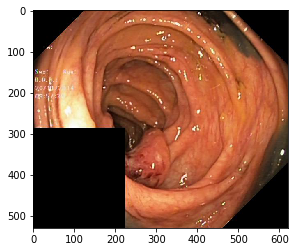

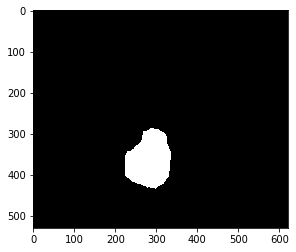

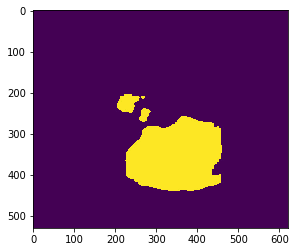

--------------------------------------------------------------------------------


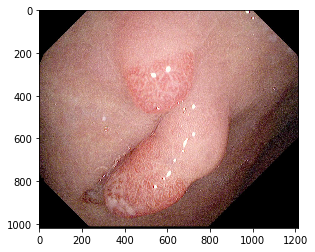

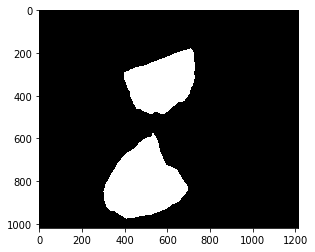

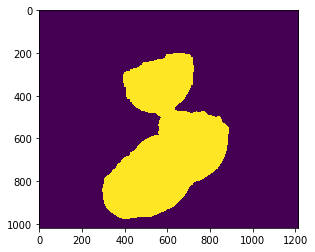

--------------------------------------------------------------------------------


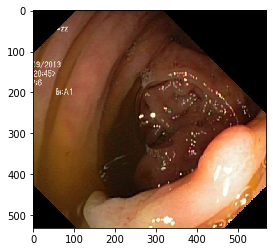

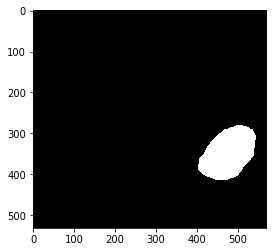

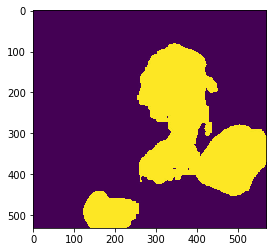

--------------------------------------------------------------------------------


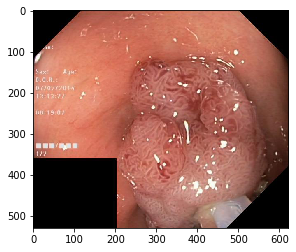

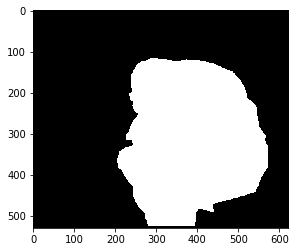

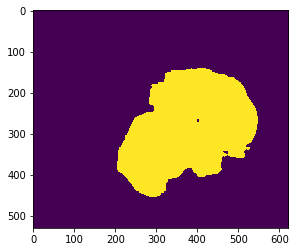

--------------------------------------------------------------------------------


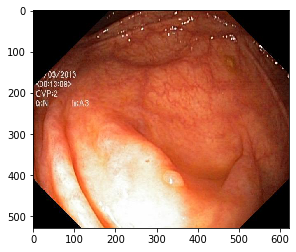

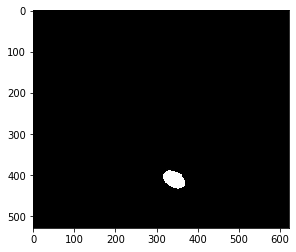

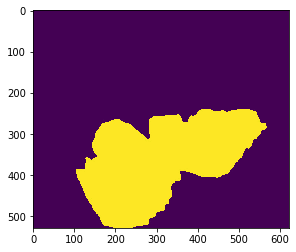

--------------------------------------------------------------------------------


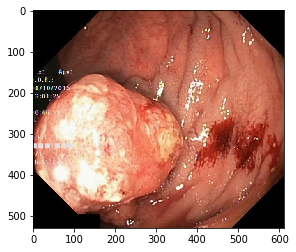

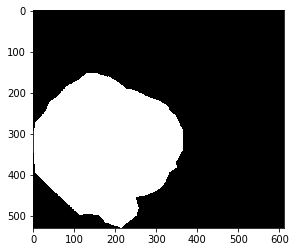

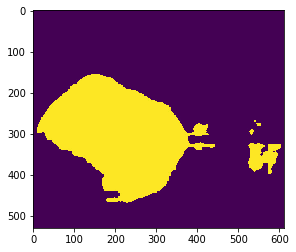

--------------------------------------------------------------------------------


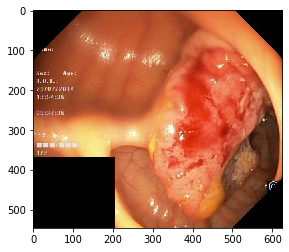

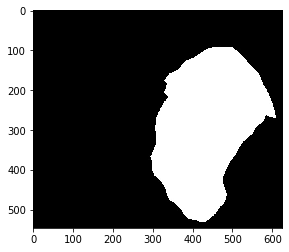

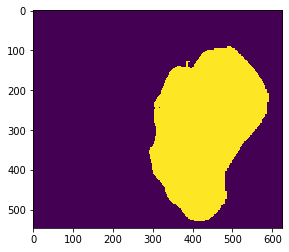

--------------------------------------------------------------------------------


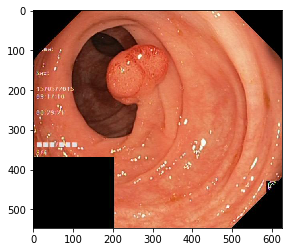

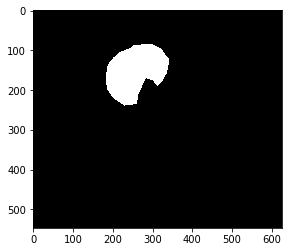

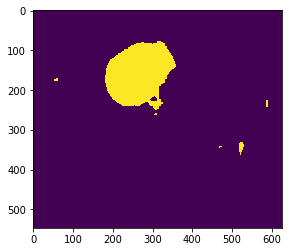

--------------------------------------------------------------------------------


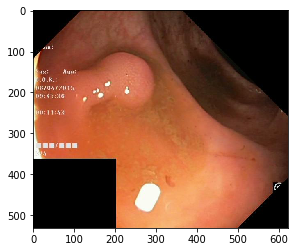

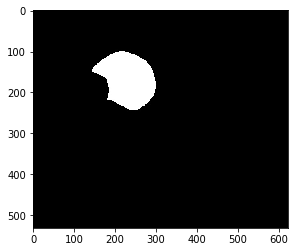

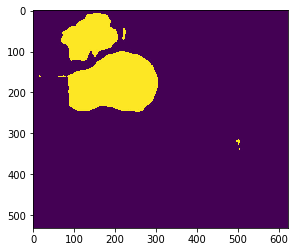

--------------------------------------------------------------------------------


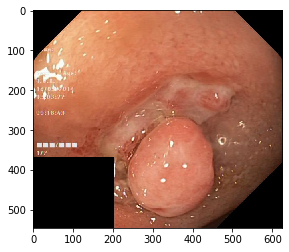

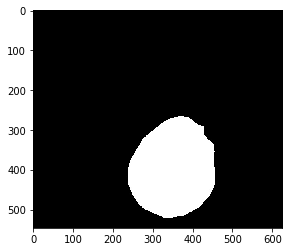

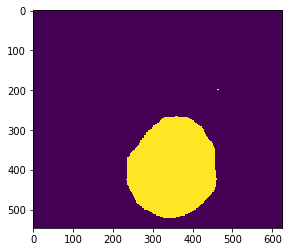

--------------------------------------------------------------------------------


In [40]:
total_imgs = 10
for i, name in enumerate(ids_val):
    
    if i == total_imgs:
        break

    img = imageio.imread(f'../datasets/train-val/images/{name}')
    plt.imshow(img)
    plt.show()
    
    mask = imageio.imread(f'../datasets/train-val/masks/{name}')
    plt.imshow(mask)
    plt.show()
    
    pred = imageio.imread(f'../predictions_val/{name}')
    plt.imshow(pred)
    plt.show()
    
    print(80 * '-')

## Produce predictions Test Set

In [32]:
%mkdir ../predictions_test

mkdir: cannot create directory ‘../predictions_test’: File exists


In [33]:
TEST_IMG_PATH = '../datasets/test/images'
os.listdir(TEST_IMG_PATH)[:20]

['ckda5qdj900053a5sm6zg4bwb.jpg',
 'ckda142i5000h3a5ssv9kauan.jpg',
 'ckdaa12yj000r3a5srr4ahcg2.jpg',
 'ckcaidxum2xrf0y6g0329hw80.jpg',
 'ckda0kbde00083a5s2296juqy.jpg',
 'ckda22o7b000v3a5s6zjzj7o3.jpg',
 'ckda9x11x000h3a5st1g20mrf.jpg',
 'ckda1jqsp000o3a5s5lh3pkdn.jpg',
 'ckcbqi8ry27wq0y7m7xqmecor.jpg',
 'ckd8sxdyn000a3b5sclphcakf.jpg',
 'ckdaa001p000n3a5shzakc3ar.jpg',
 'ckcbpz4vz28i70y5p347j9b4a.jpg',
 'ckda1ehes000j3a5sr74zgivg.jpg',
 'ckcbpmwgb267j0y5pcv7404dq.jpg',
 'ckda1j0sy000n3a5stotfjqpc.jpg',
 'ckcbsv8zd2i010y6g6te29eg7.jpg',
 'ckcbt2pbv2ptl0y5p7xea6hg3.jpg',
 'ckcbm3tjn0dyu0y4h4kbld9ro.jpg',
 'ckdaa0oyd000q3a5sabbv22b0.jpg',
 'ckcbqhgfw27qx0y7mbi0l9wn4.jpg']

In [34]:
TEST_PRED_PATH = '../predictions_test'
TEST_IMG_PATH = '../datasets/test/images'

time_taken = []
ious = []


for name in os.listdir(TEST_IMG_PATH):
    path_img = os.path.join(TEST_IMG_PATH, name)  
    img = imageio.imread(path_img) / 255
    
    # record shape to revert to 
    H, W, _ = img.shape
    resize_back = transforms.Resize((H, W), interpolation=0)
    
    # convert to Tensors and fix the dimentions (Pytorch uses the channels in the first dimension)
    img = torch.FloatTensor(np.transpose(img, [2, 0 ,1])).unsqueeze(0) 
    
    # resize for the model
    img = resize(img)
    
    # put on the GPU
    img = img.to(DEVICE)
        
    # Start time
    start_time = time.time()
    ## Prediction
    pred = model(img)
    # End timer
    end_time = time.time() - start_time

    time_taken.append(end_time)
    print("{} - {:.10f}".format(name, end_time))
        
    
    # resize back, nearest interpolation, since it's a mask
    pred = resize_back(pred)
    # put on cpu
    pred = pred.cpu()
        
    # remove channel: BATCH x 1 x H x W => BATCH x H x W
    pred = pred.squeeze(1)
        
    # comment out if your model contains a sigmoid or equivalent activation layer
    pred = torch.sigmoid(pred)
    # thresholding since that's how we will make predictions on new imputs
    pred = pred > 0.5 
    # remove BATCH => H x W
    pred = pred.squeeze(0)
    # converto to correct type
    pred = pred.numpy().astype(np.float32)
    # revert to standard intensities
    pred = pred * 255.0
    # save
    pred_path = os.path.join(TEST_PRED_PATH, name)
    cv2.imwrite(pred_path, pred)


mean_time_taken = np.mean(time_taken)
mean_fps = 1/mean_time_taken
print("\nMean FPS: ", mean_fps)

ckda5qdj900053a5sm6zg4bwb.jpg - 0.0081667900
ckda142i5000h3a5ssv9kauan.jpg - 0.0066139698
ckdaa12yj000r3a5srr4ahcg2.jpg - 0.0070762634
ckcaidxum2xrf0y6g0329hw80.jpg - 0.0066316128
ckda0kbde00083a5s2296juqy.jpg - 0.0074007511
ckda22o7b000v3a5s6zjzj7o3.jpg - 0.0073215961
ckda9x11x000h3a5st1g20mrf.jpg - 0.0070173740
ckda1jqsp000o3a5s5lh3pkdn.jpg - 0.0069468021
ckcbqi8ry27wq0y7m7xqmecor.jpg - 0.0067694187
ckd8sxdyn000a3b5sclphcakf.jpg - 0.0069441795
ckdaa001p000n3a5shzakc3ar.jpg - 0.0107524395
ckcbpz4vz28i70y5p347j9b4a.jpg - 0.0068905354
ckda1ehes000j3a5sr74zgivg.jpg - 0.0071349144
ckcbpmwgb267j0y5pcv7404dq.jpg - 0.0067336559
ckda1j0sy000n3a5stotfjqpc.jpg - 0.0068514347
ckcbsv8zd2i010y6g6te29eg7.jpg - 0.0068404675
ckcbt2pbv2ptl0y5p7xea6hg3.jpg - 0.0068972111
ckcbm3tjn0dyu0y4h4kbld9ro.jpg - 0.0069947243
ckdaa0oyd000q3a5sabbv22b0.jpg - 0.0068094730
ckcbqhgfw27qx0y7mbi0l9wn4.jpg - 0.0071010590
ckcbswp262i6n0y6g2krjfhdb.jpg - 0.0074880123
ckcbt0asc2k520y5n4e5i8c9y.jpg - 0.0077123642
ckda0hpik0